# <center><span style='background:yellow'>Améliorez le produit IA de votre start-up (partie 4)</span></center>
# <center><span style='background:yellow'>Analyse des images</span></center>
=========================================================================================================================

## Table of Contents <a class="anchor" id="sommaire"></a>

* [Import des librairies, recupération et visualisation des photos](#1)
    * [Chargement et description des données](#11)
    * [Visualisation de quelques images](#12)
* [Traitement d'image](#2)
    * [Taille de l'image](#21)
    * [Histogramme de l'image](#22)
    * [Traitement de bruit](#23)
    * [Affichage des descripteurs SIFT](#24)
* [Classification automatique d'images via SIFT](#3)
    * [Création des clusters de descripteurs](#31)  
    * [Bag of visual words](#32)     
    * [Visualisation via le TSNE](#34)   
    * [Comparaison entre les classes](#35) 
* [Utilisation du VGG-16 pré-entraîné](#4)  
    * [Visualisation via le TSNE](#44)   
    * [Comparaison entre les classes](#45)

# Import des librairies, chargement et visualisation des photos<a class="anchor" id="1"></a>

In [1]:
import os
import json

# Bibliothèques standards
import numpy as np
from numpy import random
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Traitement d'image
import cv2 as cv

# Analyse non supervisée
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

# VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import load_img, img_to_array, set_random_seed
from keras.applications.vgg16 import decode_predictions

from tqdm import tqdm

%matplotlib inline

## Chargement et description des données<a class="anchor" id="11"></a>

In [2]:
path = "C:/Users/modes/OneDrive/Documents/openclassroums/Projet6/yelp_photos/yelp_photos/"
path_photos = path + 'photos/'
print("On dispose des fichiers suivants :")
for fichier in os.listdir(path):
    print("-", fichier)

On dispose des fichiers suivants :
- Dataset_User_Agreement.pdf
- photos
- photos.json


In [3]:
# lecture du fichier "photos.json"
data_file = open(path + 'photos.json', encoding='utf-8')
json_photos = []
for line in data_file:
    json_photos.append(json.loads(line))
print(f"Le Nombre des lignes du fichier \"photos.json\" est : {len(json_photos)}")
data_file.close()

Le Nombre des lignes du fichier "photos.json" est : 200100


In [4]:
json_photos[0]

{'photo_id': 'zsvj7vloL4L5jhYyPIuVwg',
 'business_id': 'Nk-SJhPlDBkAZvfsADtccA',
 'caption': 'Nice rock artwork everywhere and craploads of taps.',
 'label': 'inside'}

In [5]:
df_photos = pd.DataFrame(json_photos)
df_photos

photo_id             business_id  \
0       zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1       HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2       vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3       pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4       H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   
...                        ...                     ...   
200095  4Zia9NkAfQNjMfcIDhwJ-g  2HxkdqHmbYGj_BH1bLaiSw   
200096  KB96KRZRhRm8hUkI-OpGEA  _gVyuTRb_6HM-SNtqbpevQ   
200097  Klmojvaf2_2dP1XKzTsFmQ  NUyEOjfAl3HvkpzSpdwqeA   
200098  FNEiq7Mogec7t31OaU5juw  hE6YsHHV0fCz_UrGS4o6VA   
200099  NHEtLh7APk7Yssjo0h45VA  VIYvcX9SScnqmoI0so1KZA   

                                                  caption    label  
0       Nice rock artwork everywhere and craploads of ...   inside  
1                                                          outside  
2                                          oyster shooter    drink  
3                                           Shrimp scampi     food  
4                                                             food  
...                                                   ...      ...  
200095                                            #Nektar     food  
200096                                                      inside  
200097                                                        food  
200098                               Drinks by the water!    drink  
200099                                                        food  

[200100 rows x 4 columns]

In [6]:
print(f'On dispose d\'un dataframe qui contient {df_photos.shape[0]} photos et {df_photos.shape[1]} variables')

On dispose d'un dataframe qui contient 200100 photos et 4 variables


In [7]:
print('Nombre des photos par label :')
df_photos.groupby('label').agg(nb_photos=('photo_id','count')).reset_index()

Nombre des photos par label :


label  nb_photos
0    drink      15670
1     food     108152
2   inside      56031
3     menu       1678
4  outside      18569

In [8]:
print("Les labels des photos sont :")
for label in df_photos.label.unique():
    print('-',label)

Les labels des photos sont :
- inside
- outside
- drink
- food
- menu


In [9]:
#On récupère 100 photos pour chaque label
seed = 0
n_photos = 200
list_photos_id = []
list_labels = []
labels = df_photos.label.unique()
for label in labels:
    df_sample = df_photos[df_photos['label'] == label].sample(n_photos, random_state=seed)
    list_photos_id.extend(df_sample['photo_id'])
    list_labels.extend(df_sample['label'])

print(f'On choisit {n_photos} photos de chaque label, on aura au total {len(list_photos_id)} photos')

On choisit 200 photos de chaque label, on aura au total 1000 photos


<a href="#sommaire" rev="footnote">&#8617;</a>

## Visualisation de quelques images<a class="anchor" id="12"></a>

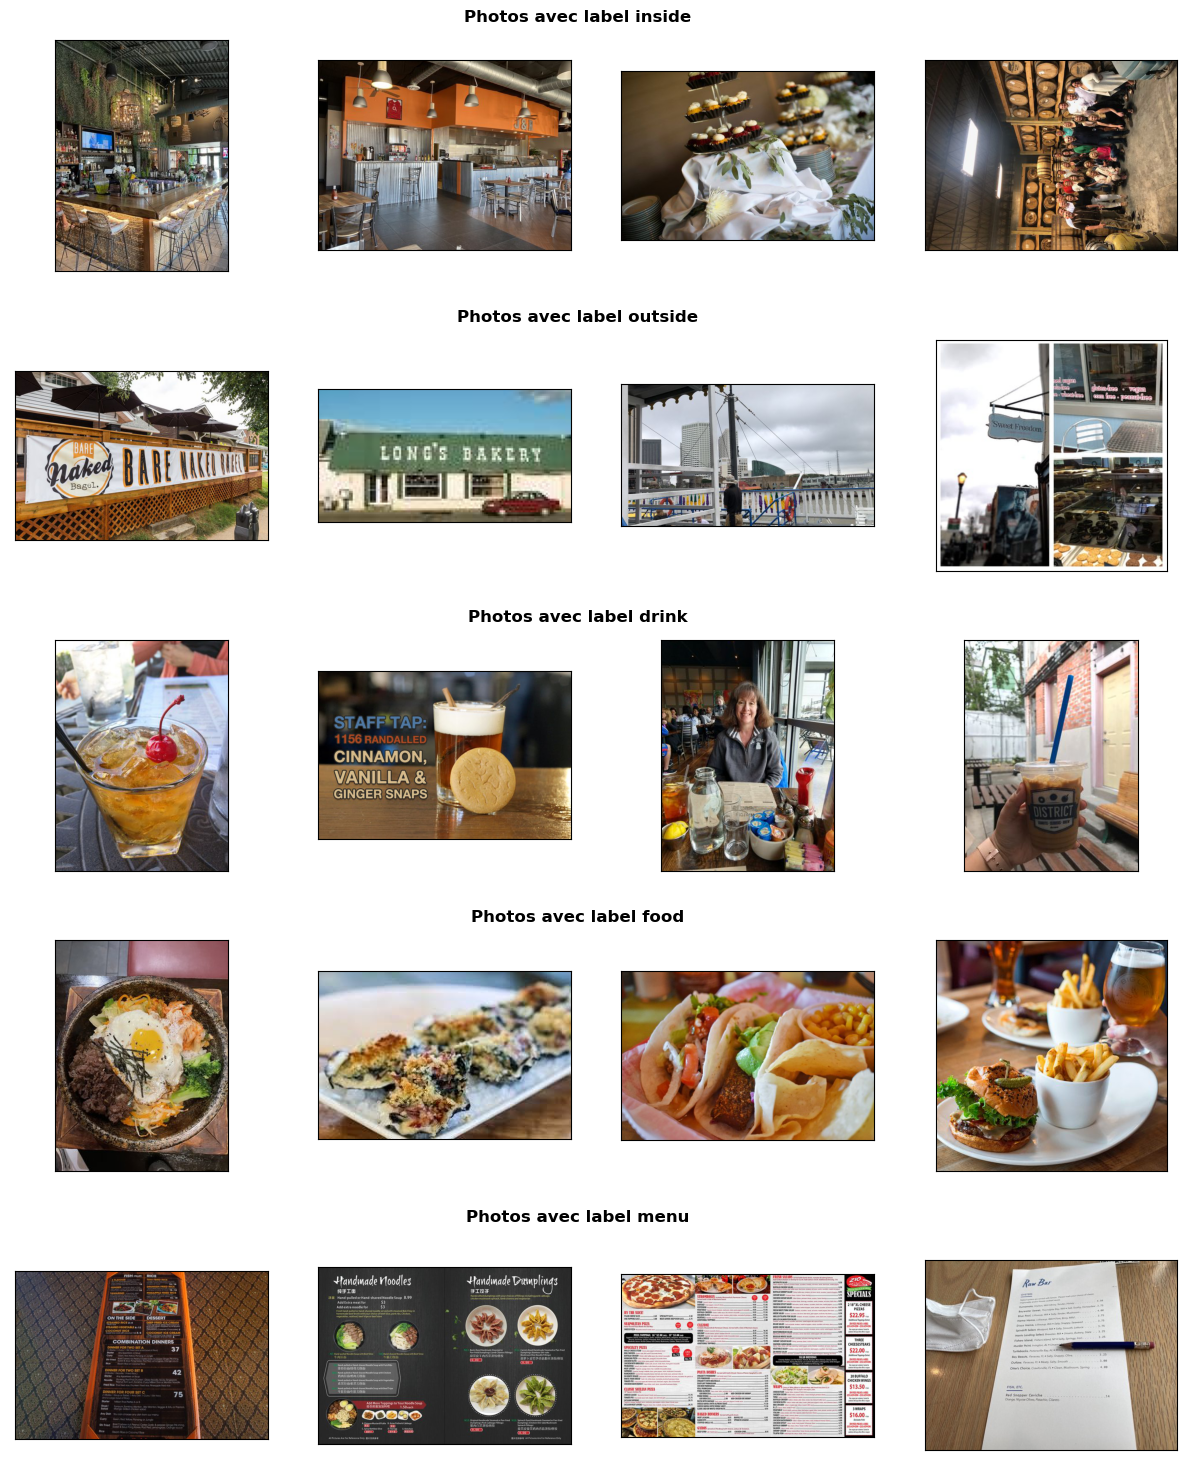

In [10]:
np.random.seed(seed)

fig = plt.figure(figsize=(15, 15))
nrows = 5
ncols = 4
subfigs = fig.subfigures(nrows, 1)
i = 0
for subfig in subfigs.flat:
    subfig.suptitle(f'Photos avec label {list_labels[i*n_photos]}')
    axs = subfig.subplots(1, ncols)
    
    # choix aléatoire de 4 photos_id pour chaque chaque labels
    short_list_photos_id = random.choice(list_photos_id[i*n_photos:(i+1)*n_photos], size=ncols, replace=False)
    
    for index, ax in enumerate(axs.flat):
        img = cv.imread(path_photos + short_list_photos_id[index] +'.jpg')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img[:,:,::-1])
        
    i += 1
        
plt.show()

fig.savefig('photos.png')

<a href="#sommaire" rev="footnote">&#8617;</a>

# Pré-traitement d'image<a class="anchor" id="2"></a>

## Taille de l'image<a class="anchor" id="21"></a>

Taile de la photo en mode BGR: 
  Largeur : 399 px 
  Hauteur : 600 px
Valeur du pixel situé en (50,10) en mode BGR: [97 90 95]


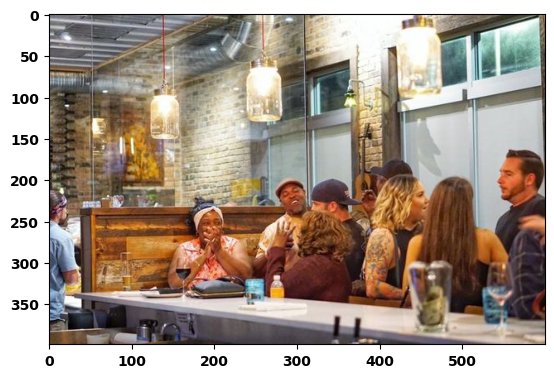

In [11]:
index_img = 100
img = cv.imread(path_photos + list_photos_id[index_img] +'.jpg')
plt.imshow(img[:,:,::-1])

#Récupérer et afficher la taille de l'image (en pixels)
w, h = img.shape[:2]
print('Taile de la photo en mode BGR: ')
print("  Largeur : {} px \n  Hauteur : {} px".format(w, h))

#Récupérer et afficher la valeur du pixel à une position précise
px_value = img[50,10]
print("Valeur du pixel situé en (50,10) en mode BGR: {}".format(px_value))

<a href="#sommaire" rev="footnote">&#8617;</a>

## Histogramme de l'image<a class="anchor" id="22"></a>

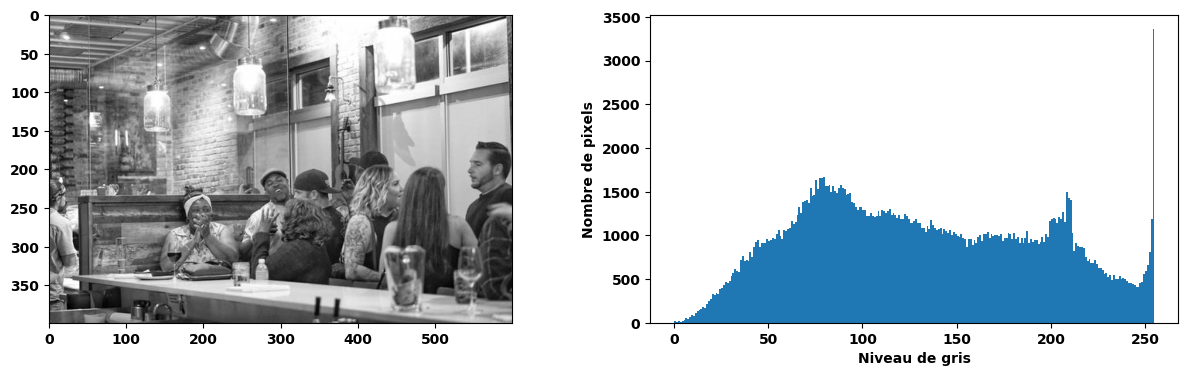

Taile de la photo: 
  Largeur : 399 px 
  Hauteur : 600 px
Valeur du pixel situé en (50,10) : 92


In [12]:
img_gris = cv.imread(path_photos + list_photos_id[index_img] +'.jpg',0)

plt.figure(figsize=(15,4))

plt.subplot(121)
plt.imshow(img_gris, 'gray')

plt.subplot(122)
plt.hist(img_gris.flatten(), bins=range(256))
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')
plt.show()

#Récupérer et afficher la taille de l'image (en pixels)
w, h = img_gris.shape
print('Taile de la photo: ')
print("  Largeur : {} px \n  Hauteur : {} px".format(w, h))

#Récupérer et afficher la valeur du pixel à une position précise
px_value = img_gris[50,10]
print("Valeur du pixel situé en (50,10) : {}".format(px_value))

<a href="#sommaire" rev="footnote">&#8617;</a>

## Traitement de bruit<a class="anchor" id="23"></a>

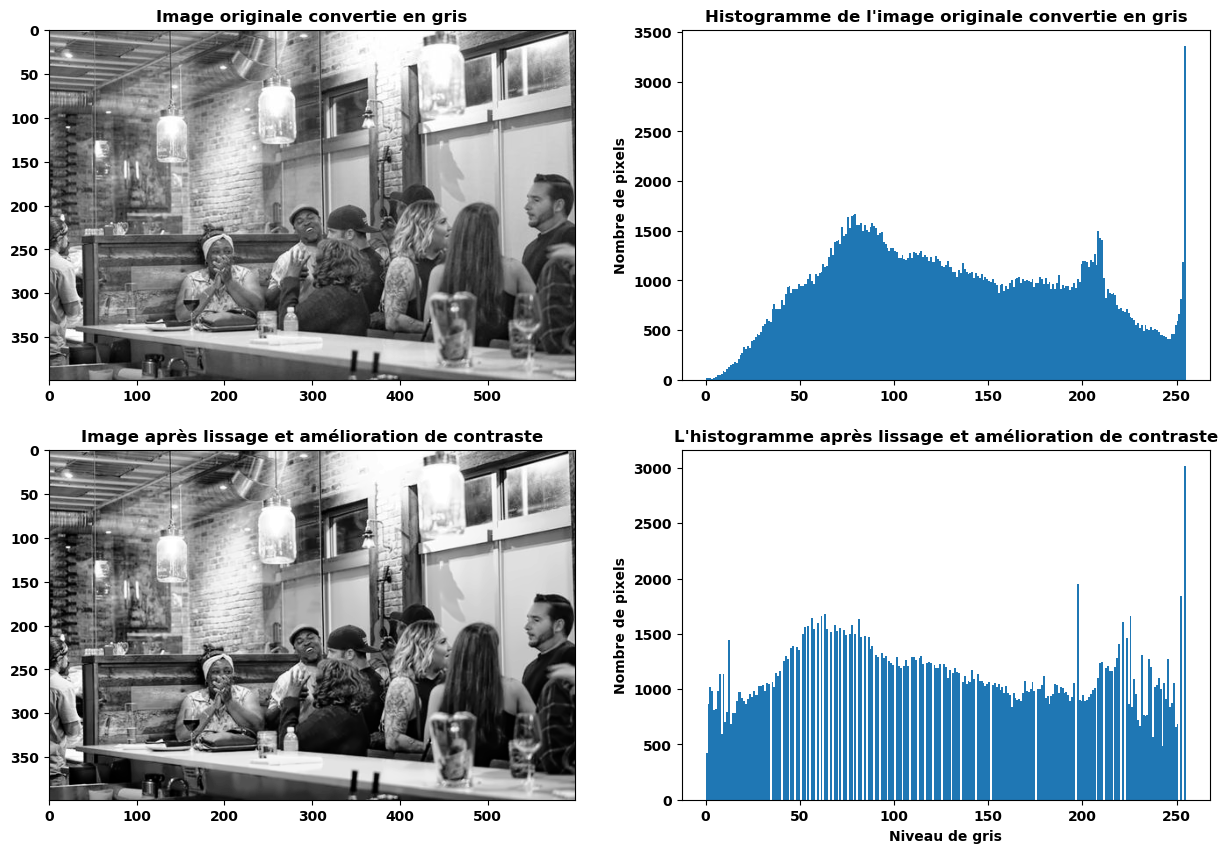

In [13]:
img = cv.imread(path_photos + list_photos_id[index_img] +'.jpg', 0)

fig = plt.figure(figsize=(15,10))

plt.subplot(221)
plt.imshow(img, 'gray')
plt.title('Image originale convertie en gris')

plt.subplot(222)
plt.hist(img.flatten(), bins=range(256))
plt.ylabel('Nombre de pixels')
plt.title('Histogramme de l\'image originale convertie en gris')

plt.subplot(223)
image_equa = cv.fastNlMeansDenoising(img)
image_equa = cv.equalizeHist(image_equa)
plt.imshow(image_equa,'gray')
plt.title('Image après lissage et amélioration de contraste')

plt.subplot(224)
plt.hist(image_equa.flatten(), bins=range(256))
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')
plt.title('L\'histogramme après lissage et amélioration de contraste')
plt.show()

fig.savefig('hist.png')

<a href="#sommaire" rev="footnote">&#8617;</a>

## Affichage des descripteurs SIFT<a class="anchor" id="24"></a>

Descripteurs shape : (2998, 128)



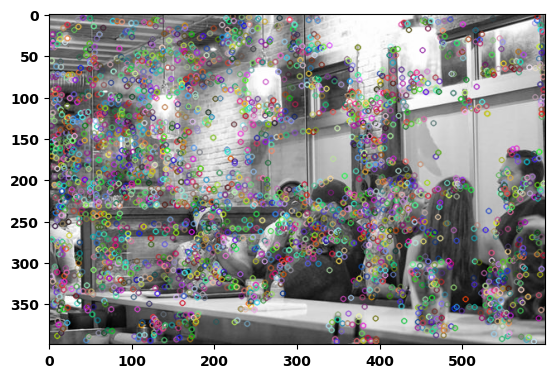

In [14]:
image = cv.imread(path_photos + list_photos_id[index_img]  + '.jpg',0) 
image = cv.fastNlMeansDenoising(image)
image = cv.equalizeHist(image)
sift = cv.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(image, None)
img = cv.drawKeypoints(img,kp,img)
plt.imshow(img, 'gray')
cv.imwrite('sift.png', img)

print("Descripteurs shape :", des.shape)
print()

<a href="#sommaire" rev="footnote">&#8617;</a>

# Classification automatique d'images via SIFT <a class="anchor" id="3"></a>

## Création des clusters de descripteurs<a class="anchor" id="31"></a>

* Pour chaque image passage en gris, lissage par Non-Local-Means et amélioration de contraste par égalisation de l'histogramme.
* Création d'une liste de descripteurs par image qui sera utilisée pour réaliser les histogrammes par image
* Création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [15]:
def pre_processing(path, image_id):
    
    # Lecture et passage en gis
    image = cv.imread(path + image_id  + '.jpg', 0) 
    
    # Lissage 
    image = cv.fastNlMeansDenoising(image)
    
    # Egalisation
    image = cv.equalizeHist(image)
    return image
    
def feature_extraction(path, image_id):
    
    # Pré-traitement
    image_cleaned = pre_processing(path, image_id)
    
    # Extraction des features
    sift = cv.xfeatures2d.SIFT_create()
    
    kp, des = sift.detectAndCompute(image_cleaned, None)
    
    image = cv.drawKeypoints(image_cleaned,kp,image_cleaned)
    
    return image, des

In [16]:
# Identification des key points des images et des descripteurs associés
sift_keypoints = []

for image_num, image_id in tqdm(enumerate(list_photos_id), total=1000) :
    
    # Pré-traitement de l'image
    image_sift, des = feature_extraction(path_photos, image_id=image_id) 
    
    # list des descripteurs
    sift_keypoints.append(des)  

sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)

print("Nombre de descripteurs : ", sift_keypoints_all.shape)

  4%|▍         | 38/1000 [00:22<09:32,  1.68it/s]


KeyboardInterrupt: 

<a href="#sommaire" rev="footnote">&#8617;</a>

## Bag of visual words<a class="anchor" id="32"></a>

* Application du Kmeans avec un nombre de cluster qui est égal au racine carré du nombre total des descripteurs.
* Création de l'histogramme par image
* Réduction de la dimensionnalité par L'ACP en gardant 99% de l'inertie totale.

In [ ]:
#Determination du nombre de clustre
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)

#Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=seed)
kmeans.fit(sift_keypoints_all)

In [ ]:
def build_histogram(kmeans, des, image_num, seed=0):
    
    res = kmeans.predict(des)
    
    hist = np.zeros(len(kmeans.cluster_centers_))
    
    nb_des = len(des)
    
    if nb_des == 0 : 
        
        print("Problème histogramme image  : ", image_num)
        
    for i in res:
        hist[i] += 1.0/nb_des
        
    return hist

In [ ]:
# Création de la matrice associée à l'histogramme par image
hist_vectors=[]

for i, image_desc in tqdm(enumerate(sift_keypoints), total=1000):
    
    # Création de l'histogramme
    hist = build_histogram(kmeans, image_desc, i) 
    
    # Liste des histogrammes par image
    hist_vectors.append(hist) 

im_features = np.asarray(hist_vectors)

In [ ]:
im_features.shape

In [ ]:
# Réduction de dimension
pca = decomposition.PCA(n_components=0.99, random_state=seed)

feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

<a href="#sommaire" rev="footnote">&#8617;</a>

## Visualisation via le TSNE<a class="anchor" id="34"></a>

In [ ]:
tsne  =  manifold.TSNE(n_components = 2, 
                     perplexity = 40, 
                     n_iter = 2000, 
                     init = 'random', 
                     random_state = seed)

X_tsne  =  tsne.fit_transform(feat_pca)

df_tsne  =  pd.DataFrame(X_tsne[:,0:2], 
                       columns = ['tsne1', 'tsne2'])

df_tsne["class"]  =  list_labels

In [ ]:
def graph_tsne(data, save=None):
    fig = plt.figure(figsize = (10,5))
    sns.scatterplot(data = data,
                    x = "tsne1", 
                    y = "tsne2", 
                    hue = "class", 
                    legend = "brief",
                    palette = 'bright')

    plt.title('TSNE selon les vraies classes', 
              fontsize = 20, 
              pad = 35, 
              fontweight = 'bold')

    plt.xlabel('tsne1', fontsize = 18, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 18, fontweight = 'bold')
    plt.legend(prop = {'size': 12}) 

    plt.show()
    if save :
        fig.savefig(save)

In [ ]:
graph_tsne(df_tsne)

<a href="#sommaire" rev="footnote">&#8617;</a>

## Comparaison entre les classes<a class="anchor" id="35"></a>

In [ ]:
cls = cluster.KMeans(n_clusters=5, random_state=seed)
cls.fit(X_tsne)

df_tsne["cluster_estimé"] = [str(x) for x in cls.labels_]
display(df_tsne.head())

In [ ]:
def graph_compare_clust_image(data, order=True, save=None):
    fig = plt.figure(figsize = (20,7))

    fig.add_subplot(121)
    
    sns.scatterplot(data = data,
                    x = "tsne1", 
                    y = "tsne2", 
                    hue = "class", 
                    legend = "brief",
                    palette = 'bright')

    plt.title('TSNE selon les vraies classes', 
              fontsize = 25, 
              pad = 35, 
              fontweight = 'bold')

    plt.xlabel('tsne1', fontsize = 18, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 18, fontweight = 'bold')
    plt.legend(prop = {'size': 12}) 

    fig.add_subplot(122)
    sns.scatterplot(data = data,
                    x = "tsne1", 
                    y = "tsne2", 
                    hue = "cluster_estimé", 
                    legend = "brief",
                    palette = 'bright')

    plt.title('TSNE selon les clusters', 
              fontsize = 25, 
              pad = 35, 
              fontweight = 'bold')

    plt.xlabel('tsne1', fontsize = 18, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 18, fontweight = 'bold')
    plt.legend(prop = {'size': 12})
    
    if order ==True :
        handles, labels = plt.gca().get_legend_handles_labels()
        order = np.argsort(labels)
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 
        plt.show()
    if save:
        fig.savefig(save)

In [ ]:
graph_compare_clust_image(df_tsne, order=True, save='clus1.png')
print("ARI : ", metrics.adjusted_rand_score(df_tsne['class'],df_tsne['cluster_estimé']))

In [ ]:
print('Nombre des photos par cluster:')
df_tsne.groupby("cluster_estimé").count().reset_index()[['cluster_estimé','class']]

In [ ]:
def conf_mat(true_labels, class_estimee, encod_dict=None):
    
    label_name = np.unique(true_labels)
    
    if encod_dict:
        class_ = class_estimee.map(encod_dict)
        class_name = np.unique(class_)
        
    else:
        class_ = class_estimee
        class_name = np.unique(class_)
    
    conf_mat = metrics.cluster.contingency_matrix(true_labels,
                                                  class_)
    
    df_cm = pd.DataFrame(conf_mat, 
                         index = label_name,
                         columns = class_name)

    return df_cm

In [ ]:
class_encod = {'0':'menu',
               '1':'food',
               '2':'drink',
               '3':'inside',
               '4':'outside'}

In [ ]:
conf_matrix = conf_mat(df_tsne['class'], df_tsne['cluster_estimé'], encod_dict=class_encod)
conf_matrix

In [ ]:
def vis_conf_mat(conf_mat, save=None):
    
    fig = plt.figure()
    ax = sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='d')

    plt.title('Matrice de confusion de (vrais labels, cluster)')
    plt.show()
    if save:
        fig.savefig(save)

In [ ]:
vis_conf_mat(conf_matrix, save='conf1.png')

In [ ]:
def report (x,y):
    print(metrics.classification_report(x,y))
report(df_tsne['class'], df_tsne['cluster_estimé'].map(class_encod))

<a href="#sommaire" rev="footnote">&#8617;</a>

# Utilisation du VGG-16 pré-entraîné<a class="anchor" id="4"></a>

In [18]:
set_random_seed(seed)

# Méthode pour traiter chaque image avant de la passer en entrée de l'algorithme
def preprocess_image(path):
    photos = path_photos + path + ".jpg"
    img = img_to_array(load_img(photos, target_size=(224, 224)))
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  
    img = preprocess_input(img) 
    return img

# On récupère dans une liste les features de chaque image calculée par le modèle VGG-16
set_random_seed
my_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Liste des features générés par le VGG-16
vgg16_feature_list = []

for photo in tqdm(list_photos_id, total=1000):

    vgg16_feature = my_VGG16.predict(preprocess_image(photo), verbose=0)
    vgg16_feature_np = np.array(vgg16_feature)
    print(vgg16_feature_np.shape)
    vgg16_feature_list.append(vgg16_feature_np.flatten())

vgg16_feature_list_np = np.array(vgg16_feature_list)
print(vgg16_feature_list_np.shape)

  0%|          | 1/1000 [00:00<10:01,  1.66it/s]

(1, 7, 7, 512)


  0%|          | 2/1000 [00:01<08:07,  2.05it/s]

(1, 7, 7, 512)


  0%|          | 3/1000 [00:01<07:42,  2.15it/s]

(1, 7, 7, 512)


  0%|          | 4/1000 [00:01<07:31,  2.21it/s]

(1, 7, 7, 512)


  0%|          | 5/1000 [00:02<07:21,  2.26it/s]

(1, 7, 7, 512)


  1%|          | 6/1000 [00:02<06:57,  2.38it/s]

(1, 7, 7, 512)


  1%|          | 7/1000 [00:03<06:52,  2.41it/s]

(1, 7, 7, 512)


  1%|          | 8/1000 [00:03<06:43,  2.46it/s]

(1, 7, 7, 512)


  1%|          | 9/1000 [00:03<06:48,  2.42it/s]

(1, 7, 7, 512)


  1%|          | 10/1000 [00:04<06:30,  2.53it/s]

(1, 7, 7, 512)


  1%|          | 11/1000 [00:04<06:25,  2.57it/s]

(1, 7, 7, 512)


  1%|          | 12/1000 [00:05<06:39,  2.48it/s]

(1, 7, 7, 512)


  1%|▏         | 13/1000 [00:05<06:31,  2.52it/s]

(1, 7, 7, 512)


  1%|▏         | 14/1000 [00:05<07:09,  2.29it/s]

(1, 7, 7, 512)


  2%|▏         | 15/1000 [00:06<07:31,  2.18it/s]

(1, 7, 7, 512)


  2%|▏         | 16/1000 [00:06<07:32,  2.18it/s]

(1, 7, 7, 512)


  2%|▏         | 17/1000 [00:07<07:29,  2.19it/s]

(1, 7, 7, 512)


  2%|▏         | 18/1000 [00:07<07:37,  2.15it/s]

(1, 7, 7, 512)


  2%|▏         | 19/1000 [00:08<07:30,  2.18it/s]

(1, 7, 7, 512)


  2%|▏         | 20/1000 [00:08<07:13,  2.26it/s]

(1, 7, 7, 512)


  2%|▏         | 21/1000 [00:09<07:00,  2.33it/s]

(1, 7, 7, 512)


  2%|▏         | 22/1000 [00:09<07:08,  2.28it/s]

(1, 7, 7, 512)


  2%|▏         | 23/1000 [00:09<06:55,  2.35it/s]

(1, 7, 7, 512)


  2%|▏         | 24/1000 [00:10<06:38,  2.45it/s]

(1, 7, 7, 512)


  2%|▎         | 25/1000 [00:10<06:52,  2.36it/s]

(1, 7, 7, 512)


  3%|▎         | 26/1000 [00:11<07:02,  2.31it/s]

(1, 7, 7, 512)


  3%|▎         | 27/1000 [00:11<07:05,  2.29it/s]

(1, 7, 7, 512)


  3%|▎         | 28/1000 [00:12<07:20,  2.21it/s]

(1, 7, 7, 512)


  3%|▎         | 29/1000 [00:12<07:26,  2.18it/s]

(1, 7, 7, 512)


  3%|▎         | 30/1000 [00:13<07:22,  2.19it/s]

(1, 7, 7, 512)


  3%|▎         | 31/1000 [00:13<07:13,  2.24it/s]

(1, 7, 7, 512)


  3%|▎         | 32/1000 [00:14<07:26,  2.17it/s]

(1, 7, 7, 512)


  3%|▎         | 33/1000 [00:14<07:37,  2.12it/s]

(1, 7, 7, 512)


  3%|▎         | 34/1000 [00:15<08:19,  1.93it/s]

(1, 7, 7, 512)


  4%|▎         | 35/1000 [00:15<08:39,  1.86it/s]

(1, 7, 7, 512)


  4%|▎         | 36/1000 [00:16<08:57,  1.79it/s]

(1, 7, 7, 512)


  4%|▎         | 37/1000 [00:16<08:40,  1.85it/s]

(1, 7, 7, 512)


  4%|▍         | 38/1000 [00:17<08:33,  1.87it/s]

(1, 7, 7, 512)


  4%|▍         | 39/1000 [00:17<08:04,  1.99it/s]

(1, 7, 7, 512)


  4%|▍         | 40/1000 [00:18<08:11,  1.95it/s]

(1, 7, 7, 512)


  4%|▍         | 41/1000 [00:18<08:25,  1.90it/s]

(1, 7, 7, 512)


  4%|▍         | 42/1000 [00:19<07:57,  2.01it/s]

(1, 7, 7, 512)


  4%|▍         | 43/1000 [00:19<07:30,  2.13it/s]

(1, 7, 7, 512)


  4%|▍         | 44/1000 [00:20<07:18,  2.18it/s]

(1, 7, 7, 512)


  4%|▍         | 45/1000 [00:20<07:41,  2.07it/s]

(1, 7, 7, 512)


  5%|▍         | 46/1000 [00:21<07:24,  2.14it/s]

(1, 7, 7, 512)


  5%|▍         | 47/1000 [00:21<07:04,  2.25it/s]

(1, 7, 7, 512)


  5%|▍         | 48/1000 [00:22<07:11,  2.20it/s]

(1, 7, 7, 512)


  5%|▍         | 49/1000 [00:22<06:55,  2.29it/s]

(1, 7, 7, 512)


  5%|▌         | 50/1000 [00:22<07:10,  2.21it/s]

(1, 7, 7, 512)


  5%|▌         | 51/1000 [00:23<06:55,  2.28it/s]

(1, 7, 7, 512)


  5%|▌         | 52/1000 [00:23<06:47,  2.33it/s]

(1, 7, 7, 512)


  5%|▌         | 53/1000 [00:24<06:34,  2.40it/s]

(1, 7, 7, 512)


  5%|▌         | 54/1000 [00:24<06:36,  2.39it/s]

(1, 7, 7, 512)


  6%|▌         | 55/1000 [00:24<06:30,  2.42it/s]

(1, 7, 7, 512)


  6%|▌         | 56/1000 [00:25<06:25,  2.45it/s]

(1, 7, 7, 512)


  6%|▌         | 57/1000 [00:25<06:12,  2.53it/s]

(1, 7, 7, 512)


  6%|▌         | 58/1000 [00:26<05:57,  2.63it/s]

(1, 7, 7, 512)


  6%|▌         | 59/1000 [00:26<06:09,  2.55it/s]

(1, 7, 7, 512)


  6%|▌         | 60/1000 [00:26<06:18,  2.49it/s]

(1, 7, 7, 512)


  6%|▌         | 61/1000 [00:27<06:59,  2.24it/s]

(1, 7, 7, 512)


  6%|▌         | 62/1000 [00:27<06:58,  2.24it/s]

(1, 7, 7, 512)


  6%|▋         | 63/1000 [00:28<06:36,  2.36it/s]

(1, 7, 7, 512)


  6%|▋         | 64/1000 [00:28<06:39,  2.34it/s]

(1, 7, 7, 512)


  6%|▋         | 65/1000 [00:29<06:35,  2.36it/s]

(1, 7, 7, 512)


  7%|▋         | 66/1000 [00:29<07:11,  2.16it/s]

(1, 7, 7, 512)


  7%|▋         | 67/1000 [00:30<07:28,  2.08it/s]

(1, 7, 7, 512)


  7%|▋         | 68/1000 [00:30<07:37,  2.04it/s]

(1, 7, 7, 512)


  7%|▋         | 69/1000 [00:31<07:49,  1.98it/s]

(1, 7, 7, 512)


  7%|▋         | 70/1000 [00:31<07:32,  2.06it/s]

(1, 7, 7, 512)


  7%|▋         | 71/1000 [00:32<07:36,  2.03it/s]

(1, 7, 7, 512)


  7%|▋         | 72/1000 [00:32<07:49,  1.98it/s]

(1, 7, 7, 512)


  7%|▋         | 73/1000 [00:33<07:42,  2.01it/s]

(1, 7, 7, 512)


  7%|▋         | 74/1000 [00:33<07:54,  1.95it/s]

(1, 7, 7, 512)


  8%|▊         | 75/1000 [00:34<07:27,  2.07it/s]

(1, 7, 7, 512)


  8%|▊         | 76/1000 [00:34<06:51,  2.25it/s]

(1, 7, 7, 512)


  8%|▊         | 77/1000 [00:34<06:30,  2.37it/s]

(1, 7, 7, 512)


  8%|▊         | 78/1000 [00:35<06:47,  2.26it/s]

(1, 7, 7, 512)


  8%|▊         | 79/1000 [00:35<06:58,  2.20it/s]

(1, 7, 7, 512)


  8%|▊         | 80/1000 [00:36<07:07,  2.15it/s]

(1, 7, 7, 512)


  8%|▊         | 81/1000 [00:36<07:20,  2.09it/s]

(1, 7, 7, 512)


  8%|▊         | 82/1000 [00:37<07:44,  1.98it/s]

(1, 7, 7, 512)


  8%|▊         | 83/1000 [00:37<07:51,  1.95it/s]

(1, 7, 7, 512)


  8%|▊         | 84/1000 [00:38<07:34,  2.01it/s]

(1, 7, 7, 512)


  8%|▊         | 85/1000 [00:38<07:17,  2.09it/s]

(1, 7, 7, 512)


  9%|▊         | 86/1000 [00:39<06:59,  2.18it/s]

(1, 7, 7, 512)


  9%|▊         | 87/1000 [00:39<06:52,  2.21it/s]

(1, 7, 7, 512)


  9%|▉         | 88/1000 [00:40<06:45,  2.25it/s]

(1, 7, 7, 512)


  9%|▉         | 89/1000 [00:40<06:29,  2.34it/s]

(1, 7, 7, 512)


  9%|▉         | 90/1000 [00:40<06:20,  2.39it/s]

(1, 7, 7, 512)


  9%|▉         | 91/1000 [00:41<06:32,  2.32it/s]

(1, 7, 7, 512)


  9%|▉         | 92/1000 [00:41<06:21,  2.38it/s]

(1, 7, 7, 512)


  9%|▉         | 93/1000 [00:42<06:07,  2.47it/s]

(1, 7, 7, 512)


  9%|▉         | 94/1000 [00:42<06:09,  2.45it/s]

(1, 7, 7, 512)


 10%|▉         | 95/1000 [00:42<06:03,  2.49it/s]

(1, 7, 7, 512)


 10%|▉         | 96/1000 [00:43<05:55,  2.55it/s]

(1, 7, 7, 512)


 10%|▉         | 97/1000 [00:43<06:04,  2.48it/s]

(1, 7, 7, 512)


 10%|▉         | 98/1000 [00:44<05:53,  2.55it/s]

(1, 7, 7, 512)


 10%|▉         | 99/1000 [00:44<05:58,  2.51it/s]

(1, 7, 7, 512)


 10%|█         | 100/1000 [00:44<05:53,  2.54it/s]

(1, 7, 7, 512)


 10%|█         | 101/1000 [00:45<05:54,  2.54it/s]

(1, 7, 7, 512)


 10%|█         | 102/1000 [00:45<06:22,  2.34it/s]

(1, 7, 7, 512)


 10%|█         | 103/1000 [00:46<06:43,  2.22it/s]

(1, 7, 7, 512)


 10%|█         | 104/1000 [00:46<06:28,  2.31it/s]

(1, 7, 7, 512)


 10%|█         | 105/1000 [00:47<06:10,  2.42it/s]

(1, 7, 7, 512)


 11%|█         | 106/1000 [00:47<06:05,  2.44it/s]

(1, 7, 7, 512)


 11%|█         | 107/1000 [00:47<06:00,  2.48it/s]

(1, 7, 7, 512)


 11%|█         | 108/1000 [00:48<05:53,  2.52it/s]

(1, 7, 7, 512)


 11%|█         | 109/1000 [00:48<05:46,  2.57it/s]

(1, 7, 7, 512)


 11%|█         | 110/1000 [00:48<05:37,  2.64it/s]

(1, 7, 7, 512)


 11%|█         | 111/1000 [00:49<05:36,  2.64it/s]

(1, 7, 7, 512)


 11%|█         | 112/1000 [00:49<05:36,  2.64it/s]

(1, 7, 7, 512)


 11%|█▏        | 113/1000 [00:50<05:42,  2.59it/s]

(1, 7, 7, 512)


 11%|█▏        | 114/1000 [00:50<05:35,  2.64it/s]

(1, 7, 7, 512)


 12%|█▏        | 115/1000 [00:50<05:24,  2.72it/s]

(1, 7, 7, 512)


 12%|█▏        | 116/1000 [00:51<05:58,  2.47it/s]

(1, 7, 7, 512)


 12%|█▏        | 117/1000 [00:51<06:14,  2.36it/s]

(1, 7, 7, 512)


 12%|█▏        | 118/1000 [00:52<06:32,  2.24it/s]

(1, 7, 7, 512)


 12%|█▏        | 119/1000 [00:52<06:55,  2.12it/s]

(1, 7, 7, 512)


 12%|█▏        | 120/1000 [00:53<07:03,  2.08it/s]

(1, 7, 7, 512)


 12%|█▏        | 121/1000 [00:53<07:38,  1.92it/s]

(1, 7, 7, 512)


 12%|█▏        | 122/1000 [00:54<07:44,  1.89it/s]

(1, 7, 7, 512)


 12%|█▏        | 123/1000 [00:54<07:34,  1.93it/s]

(1, 7, 7, 512)


 12%|█▏        | 124/1000 [00:55<07:39,  1.90it/s]

(1, 7, 7, 512)


 12%|█▎        | 125/1000 [00:55<07:08,  2.04it/s]

(1, 7, 7, 512)


 13%|█▎        | 126/1000 [00:56<06:47,  2.15it/s]

(1, 7, 7, 512)


 13%|█▎        | 127/1000 [00:56<06:51,  2.12it/s]

(1, 7, 7, 512)


 13%|█▎        | 128/1000 [00:57<06:39,  2.18it/s]

(1, 7, 7, 512)


 13%|█▎        | 129/1000 [00:57<06:58,  2.08it/s]

(1, 7, 7, 512)


 13%|█▎        | 130/1000 [00:58<06:40,  2.17it/s]

(1, 7, 7, 512)


 13%|█▎        | 131/1000 [00:58<06:25,  2.26it/s]

(1, 7, 7, 512)


 13%|█▎        | 132/1000 [00:59<06:22,  2.27it/s]

(1, 7, 7, 512)


 13%|█▎        | 133/1000 [00:59<06:10,  2.34it/s]

(1, 7, 7, 512)


 13%|█▎        | 134/1000 [00:59<06:03,  2.38it/s]

(1, 7, 7, 512)


 14%|█▎        | 135/1000 [01:00<06:00,  2.40it/s]

(1, 7, 7, 512)


 14%|█▎        | 136/1000 [01:00<06:23,  2.25it/s]

(1, 7, 7, 512)


 14%|█▎        | 137/1000 [01:01<06:52,  2.09it/s]

(1, 7, 7, 512)


 14%|█▍        | 138/1000 [01:01<07:14,  1.99it/s]

(1, 7, 7, 512)


 14%|█▍        | 139/1000 [01:02<07:41,  1.87it/s]

(1, 7, 7, 512)


 14%|█▍        | 140/1000 [01:03<08:10,  1.75it/s]

(1, 7, 7, 512)


 14%|█▍        | 141/1000 [01:03<08:17,  1.73it/s]

(1, 7, 7, 512)


 14%|█▍        | 142/1000 [01:04<08:16,  1.73it/s]

(1, 7, 7, 512)


 14%|█▍        | 143/1000 [01:04<08:14,  1.73it/s]

(1, 7, 7, 512)


 14%|█▍        | 144/1000 [01:05<07:41,  1.85it/s]

(1, 7, 7, 512)


 14%|█▍        | 145/1000 [01:05<07:06,  2.01it/s]

(1, 7, 7, 512)


 15%|█▍        | 146/1000 [01:06<06:55,  2.05it/s]

(1, 7, 7, 512)


 15%|█▍        | 147/1000 [01:06<06:43,  2.11it/s]

(1, 7, 7, 512)


 15%|█▍        | 148/1000 [01:07<06:35,  2.16it/s]

(1, 7, 7, 512)


 15%|█▍        | 149/1000 [01:07<06:55,  2.05it/s]

(1, 7, 7, 512)


 15%|█▌        | 150/1000 [01:08<06:41,  2.12it/s]

(1, 7, 7, 512)


 15%|█▌        | 151/1000 [01:08<06:59,  2.03it/s]

(1, 7, 7, 512)


 15%|█▌        | 152/1000 [01:09<07:01,  2.01it/s]

(1, 7, 7, 512)


 15%|█▌        | 153/1000 [01:09<07:06,  1.98it/s]

(1, 7, 7, 512)


 15%|█▌        | 154/1000 [01:10<07:06,  1.98it/s]

(1, 7, 7, 512)


 16%|█▌        | 155/1000 [01:10<06:47,  2.08it/s]

(1, 7, 7, 512)


 16%|█▌        | 156/1000 [01:10<06:39,  2.11it/s]

(1, 7, 7, 512)


 16%|█▌        | 157/1000 [01:11<06:36,  2.12it/s]

(1, 7, 7, 512)


 16%|█▌        | 158/1000 [01:11<06:08,  2.29it/s]

(1, 7, 7, 512)


 16%|█▌        | 159/1000 [01:12<05:56,  2.36it/s]

(1, 7, 7, 512)


 16%|█▌        | 160/1000 [01:12<05:46,  2.42it/s]

(1, 7, 7, 512)


 16%|█▌        | 161/1000 [01:12<05:41,  2.46it/s]

(1, 7, 7, 512)


 16%|█▌        | 162/1000 [01:13<06:08,  2.27it/s]

(1, 7, 7, 512)


 16%|█▋        | 163/1000 [01:13<05:56,  2.35it/s]

(1, 7, 7, 512)


 16%|█▋        | 164/1000 [01:14<05:47,  2.40it/s]

(1, 7, 7, 512)


 16%|█▋        | 165/1000 [01:14<05:52,  2.37it/s]

(1, 7, 7, 512)


 17%|█▋        | 166/1000 [01:15<05:39,  2.46it/s]

(1, 7, 7, 512)


 17%|█▋        | 167/1000 [01:15<06:06,  2.27it/s]

(1, 7, 7, 512)


 17%|█▋        | 168/1000 [01:16<06:40,  2.08it/s]

(1, 7, 7, 512)


 17%|█▋        | 169/1000 [01:16<06:49,  2.03it/s]

(1, 7, 7, 512)


 17%|█▋        | 170/1000 [01:17<06:32,  2.11it/s]

(1, 7, 7, 512)


 17%|█▋        | 171/1000 [01:17<06:21,  2.17it/s]

(1, 7, 7, 512)


 17%|█▋        | 172/1000 [01:18<06:34,  2.10it/s]

(1, 7, 7, 512)


 17%|█▋        | 173/1000 [01:18<06:17,  2.19it/s]

(1, 7, 7, 512)


 17%|█▋        | 174/1000 [01:18<06:26,  2.14it/s]

(1, 7, 7, 512)


 18%|█▊        | 175/1000 [01:19<06:15,  2.20it/s]

(1, 7, 7, 512)


 18%|█▊        | 176/1000 [01:19<05:56,  2.31it/s]

(1, 7, 7, 512)


 18%|█▊        | 177/1000 [01:20<05:52,  2.33it/s]

(1, 7, 7, 512)


 18%|█▊        | 178/1000 [01:20<05:28,  2.50it/s]

(1, 7, 7, 512)


 18%|█▊        | 179/1000 [01:20<05:37,  2.43it/s]

(1, 7, 7, 512)


 18%|█▊        | 180/1000 [01:21<05:44,  2.38it/s]

(1, 7, 7, 512)


 18%|█▊        | 181/1000 [01:21<05:29,  2.49it/s]

(1, 7, 7, 512)


 18%|█▊        | 182/1000 [01:22<05:10,  2.64it/s]

(1, 7, 7, 512)


 18%|█▊        | 183/1000 [01:22<05:08,  2.64it/s]

(1, 7, 7, 512)


 18%|█▊        | 184/1000 [01:22<05:03,  2.69it/s]

(1, 7, 7, 512)


 18%|█▊        | 185/1000 [01:23<04:56,  2.75it/s]

(1, 7, 7, 512)


 19%|█▊        | 186/1000 [01:23<04:57,  2.74it/s]

(1, 7, 7, 512)


 19%|█▊        | 187/1000 [01:23<05:06,  2.65it/s]

(1, 7, 7, 512)


 19%|█▉        | 188/1000 [01:24<05:00,  2.70it/s]

(1, 7, 7, 512)


 19%|█▉        | 189/1000 [01:24<04:57,  2.73it/s]

(1, 7, 7, 512)


 19%|█▉        | 190/1000 [01:25<05:15,  2.57it/s]

(1, 7, 7, 512)


 19%|█▉        | 191/1000 [01:25<05:32,  2.43it/s]

(1, 7, 7, 512)


 19%|█▉        | 192/1000 [01:25<05:29,  2.45it/s]

(1, 7, 7, 512)


 19%|█▉        | 193/1000 [01:26<05:36,  2.40it/s]

(1, 7, 7, 512)


 19%|█▉        | 194/1000 [01:26<05:27,  2.46it/s]

(1, 7, 7, 512)


 20%|█▉        | 195/1000 [01:27<05:12,  2.58it/s]

(1, 7, 7, 512)


 20%|█▉        | 196/1000 [01:27<05:09,  2.60it/s]

(1, 7, 7, 512)


 20%|█▉        | 197/1000 [01:27<05:04,  2.64it/s]

(1, 7, 7, 512)


 20%|█▉        | 198/1000 [01:28<04:56,  2.70it/s]

(1, 7, 7, 512)


 20%|█▉        | 199/1000 [01:28<04:57,  2.69it/s]

(1, 7, 7, 512)


 20%|██        | 200/1000 [01:29<05:01,  2.66it/s]

(1, 7, 7, 512)


 20%|██        | 201/1000 [01:29<04:58,  2.68it/s]

(1, 7, 7, 512)


 20%|██        | 202/1000 [01:29<05:15,  2.53it/s]

(1, 7, 7, 512)


 20%|██        | 203/1000 [01:30<05:12,  2.55it/s]

(1, 7, 7, 512)


 20%|██        | 204/1000 [01:30<05:11,  2.55it/s]

(1, 7, 7, 512)


 20%|██        | 205/1000 [01:30<05:07,  2.58it/s]

(1, 7, 7, 512)


 21%|██        | 206/1000 [01:31<05:12,  2.54it/s]

(1, 7, 7, 512)


 21%|██        | 207/1000 [01:31<05:09,  2.56it/s]

(1, 7, 7, 512)


 21%|██        | 208/1000 [01:32<05:22,  2.46it/s]

(1, 7, 7, 512)


 21%|██        | 209/1000 [01:32<05:27,  2.42it/s]

(1, 7, 7, 512)


 21%|██        | 210/1000 [01:33<05:48,  2.27it/s]

(1, 7, 7, 512)


 21%|██        | 211/1000 [01:33<05:32,  2.37it/s]

(1, 7, 7, 512)


 21%|██        | 212/1000 [01:33<05:13,  2.51it/s]

(1, 7, 7, 512)


 21%|██▏       | 213/1000 [01:34<05:12,  2.52it/s]

(1, 7, 7, 512)


 21%|██▏       | 214/1000 [01:34<05:28,  2.40it/s]

(1, 7, 7, 512)


 22%|██▏       | 215/1000 [01:35<05:23,  2.43it/s]

(1, 7, 7, 512)


 22%|██▏       | 216/1000 [01:35<05:23,  2.42it/s]

(1, 7, 7, 512)


 22%|██▏       | 217/1000 [01:35<05:16,  2.47it/s]

(1, 7, 7, 512)


 22%|██▏       | 218/1000 [01:36<05:37,  2.32it/s]

(1, 7, 7, 512)


 22%|██▏       | 219/1000 [01:36<05:26,  2.40it/s]

(1, 7, 7, 512)


 22%|██▏       | 220/1000 [01:37<05:14,  2.48it/s]

(1, 7, 7, 512)


 22%|██▏       | 221/1000 [01:37<05:11,  2.50it/s]

(1, 7, 7, 512)


 22%|██▏       | 222/1000 [01:37<05:16,  2.46it/s]

(1, 7, 7, 512)


 22%|██▏       | 223/1000 [01:38<05:05,  2.54it/s]

(1, 7, 7, 512)


 22%|██▏       | 224/1000 [01:38<04:58,  2.60it/s]

(1, 7, 7, 512)


 22%|██▎       | 225/1000 [01:39<04:54,  2.63it/s]

(1, 7, 7, 512)


 23%|██▎       | 226/1000 [01:39<04:59,  2.58it/s]

(1, 7, 7, 512)


 23%|██▎       | 227/1000 [01:39<04:54,  2.62it/s]

(1, 7, 7, 512)


 23%|██▎       | 228/1000 [01:40<04:46,  2.69it/s]

(1, 7, 7, 512)


 23%|██▎       | 229/1000 [01:40<04:53,  2.63it/s]

(1, 7, 7, 512)


 23%|██▎       | 230/1000 [01:41<05:10,  2.48it/s]

(1, 7, 7, 512)


 23%|██▎       | 231/1000 [01:41<05:35,  2.29it/s]

(1, 7, 7, 512)


 23%|██▎       | 232/1000 [01:42<05:38,  2.27it/s]

(1, 7, 7, 512)


 23%|██▎       | 233/1000 [01:42<05:49,  2.20it/s]

(1, 7, 7, 512)


 23%|██▎       | 234/1000 [01:43<06:06,  2.09it/s]

(1, 7, 7, 512)


 24%|██▎       | 235/1000 [01:43<06:08,  2.07it/s]

(1, 7, 7, 512)


 24%|██▎       | 236/1000 [01:43<05:56,  2.14it/s]

(1, 7, 7, 512)


 24%|██▎       | 237/1000 [01:44<06:12,  2.05it/s]

(1, 7, 7, 512)


 24%|██▍       | 238/1000 [01:45<06:28,  1.96it/s]

(1, 7, 7, 512)


 24%|██▍       | 239/1000 [01:45<06:22,  1.99it/s]

(1, 7, 7, 512)


 24%|██▍       | 240/1000 [01:46<06:13,  2.04it/s]

(1, 7, 7, 512)


 24%|██▍       | 241/1000 [01:46<05:56,  2.13it/s]

(1, 7, 7, 512)


 24%|██▍       | 242/1000 [01:46<05:46,  2.19it/s]

(1, 7, 7, 512)


 24%|██▍       | 243/1000 [01:47<05:40,  2.22it/s]

(1, 7, 7, 512)


 24%|██▍       | 244/1000 [01:47<05:49,  2.16it/s]

(1, 7, 7, 512)


 24%|██▍       | 245/1000 [01:48<05:43,  2.20it/s]

(1, 7, 7, 512)


 25%|██▍       | 246/1000 [01:48<05:35,  2.25it/s]

(1, 7, 7, 512)


 25%|██▍       | 247/1000 [01:49<05:28,  2.29it/s]

(1, 7, 7, 512)


 25%|██▍       | 248/1000 [01:49<05:26,  2.31it/s]

(1, 7, 7, 512)


 25%|██▍       | 249/1000 [01:49<05:19,  2.35it/s]

(1, 7, 7, 512)


 25%|██▌       | 250/1000 [01:50<05:14,  2.38it/s]

(1, 7, 7, 512)


 25%|██▌       | 251/1000 [01:50<05:14,  2.38it/s]

(1, 7, 7, 512)


 25%|██▌       | 252/1000 [01:51<05:21,  2.33it/s]

(1, 7, 7, 512)


 25%|██▌       | 253/1000 [01:51<05:30,  2.26it/s]

(1, 7, 7, 512)


 25%|██▌       | 254/1000 [01:52<05:16,  2.36it/s]

(1, 7, 7, 512)


 26%|██▌       | 255/1000 [01:52<05:13,  2.38it/s]

(1, 7, 7, 512)


 26%|██▌       | 256/1000 [01:52<05:08,  2.41it/s]

(1, 7, 7, 512)


 26%|██▌       | 257/1000 [01:53<05:01,  2.46it/s]

(1, 7, 7, 512)


 26%|██▌       | 258/1000 [01:53<05:05,  2.43it/s]

(1, 7, 7, 512)


 26%|██▌       | 259/1000 [01:54<05:17,  2.34it/s]

(1, 7, 7, 512)


 26%|██▌       | 260/1000 [01:54<05:15,  2.35it/s]

(1, 7, 7, 512)


 26%|██▌       | 261/1000 [01:54<05:12,  2.36it/s]

(1, 7, 7, 512)


 26%|██▌       | 262/1000 [01:55<05:20,  2.30it/s]

(1, 7, 7, 512)


 26%|██▋       | 263/1000 [01:55<05:15,  2.34it/s]

(1, 7, 7, 512)


 26%|██▋       | 264/1000 [01:56<05:07,  2.39it/s]

(1, 7, 7, 512)


 26%|██▋       | 265/1000 [01:56<05:07,  2.39it/s]

(1, 7, 7, 512)


 27%|██▋       | 266/1000 [01:57<05:03,  2.42it/s]

(1, 7, 7, 512)


 27%|██▋       | 267/1000 [01:57<05:02,  2.42it/s]

(1, 7, 7, 512)


 27%|██▋       | 268/1000 [01:57<04:55,  2.47it/s]

(1, 7, 7, 512)


 27%|██▋       | 269/1000 [01:58<04:53,  2.49it/s]

(1, 7, 7, 512)


 27%|██▋       | 270/1000 [01:58<05:00,  2.43it/s]

(1, 7, 7, 512)


 27%|██▋       | 271/1000 [01:59<04:51,  2.50it/s]

(1, 7, 7, 512)


 27%|██▋       | 272/1000 [01:59<05:02,  2.40it/s]

(1, 7, 7, 512)


 27%|██▋       | 273/1000 [01:59<04:58,  2.43it/s]

(1, 7, 7, 512)


 27%|██▋       | 274/1000 [02:00<05:02,  2.40it/s]

(1, 7, 7, 512)


 28%|██▊       | 275/1000 [02:00<04:59,  2.42it/s]

(1, 7, 7, 512)


 28%|██▊       | 276/1000 [02:01<04:53,  2.47it/s]

(1, 7, 7, 512)


 28%|██▊       | 277/1000 [02:01<04:47,  2.52it/s]

(1, 7, 7, 512)


 28%|██▊       | 278/1000 [02:01<04:42,  2.56it/s]

(1, 7, 7, 512)


 28%|██▊       | 279/1000 [02:02<04:46,  2.52it/s]

(1, 7, 7, 512)


 28%|██▊       | 280/1000 [02:02<04:45,  2.52it/s]

(1, 7, 7, 512)


 28%|██▊       | 281/1000 [02:03<04:46,  2.51it/s]

(1, 7, 7, 512)


 28%|██▊       | 282/1000 [02:03<04:52,  2.45it/s]

(1, 7, 7, 512)


 28%|██▊       | 283/1000 [02:03<04:47,  2.49it/s]

(1, 7, 7, 512)


 28%|██▊       | 284/1000 [02:04<04:47,  2.49it/s]

(1, 7, 7, 512)


 28%|██▊       | 285/1000 [02:04<04:46,  2.49it/s]

(1, 7, 7, 512)


 29%|██▊       | 286/1000 [02:05<04:46,  2.49it/s]

(1, 7, 7, 512)


 29%|██▊       | 287/1000 [02:05<04:59,  2.38it/s]

(1, 7, 7, 512)


 29%|██▉       | 288/1000 [02:05<04:55,  2.41it/s]

(1, 7, 7, 512)


 29%|██▉       | 289/1000 [02:06<04:54,  2.41it/s]

(1, 7, 7, 512)


 29%|██▉       | 290/1000 [02:06<05:02,  2.35it/s]

(1, 7, 7, 512)


 29%|██▉       | 291/1000 [02:07<04:54,  2.41it/s]

(1, 7, 7, 512)


 29%|██▉       | 292/1000 [02:07<04:54,  2.40it/s]

(1, 7, 7, 512)


 29%|██▉       | 293/1000 [02:08<04:55,  2.39it/s]

(1, 7, 7, 512)


 29%|██▉       | 294/1000 [02:08<04:49,  2.44it/s]

(1, 7, 7, 512)


 30%|██▉       | 295/1000 [02:08<04:39,  2.52it/s]

(1, 7, 7, 512)


 30%|██▉       | 296/1000 [02:09<04:45,  2.47it/s]

(1, 7, 7, 512)


 30%|██▉       | 297/1000 [02:09<04:44,  2.47it/s]

(1, 7, 7, 512)


 30%|██▉       | 298/1000 [02:10<04:34,  2.55it/s]

(1, 7, 7, 512)


 30%|██▉       | 299/1000 [02:10<04:33,  2.57it/s]

(1, 7, 7, 512)


 30%|███       | 300/1000 [02:10<04:30,  2.59it/s]

(1, 7, 7, 512)


 30%|███       | 301/1000 [02:11<04:32,  2.57it/s]

(1, 7, 7, 512)


 30%|███       | 302/1000 [02:11<04:34,  2.54it/s]

(1, 7, 7, 512)


 30%|███       | 303/1000 [02:11<04:22,  2.65it/s]

(1, 7, 7, 512)


 30%|███       | 304/1000 [02:12<04:15,  2.73it/s]

(1, 7, 7, 512)


 30%|███       | 305/1000 [02:12<04:30,  2.57it/s]

(1, 7, 7, 512)


 31%|███       | 306/1000 [02:13<04:27,  2.59it/s]

(1, 7, 7, 512)


 31%|███       | 307/1000 [02:13<04:26,  2.60it/s]

(1, 7, 7, 512)


 31%|███       | 308/1000 [02:13<04:26,  2.60it/s]

(1, 7, 7, 512)


 31%|███       | 309/1000 [02:14<04:21,  2.65it/s]

(1, 7, 7, 512)


 31%|███       | 310/1000 [02:14<04:24,  2.60it/s]

(1, 7, 7, 512)


 31%|███       | 311/1000 [02:14<04:21,  2.64it/s]

(1, 7, 7, 512)


 31%|███       | 312/1000 [02:15<04:22,  2.62it/s]

(1, 7, 7, 512)


 31%|███▏      | 313/1000 [02:15<04:38,  2.46it/s]

(1, 7, 7, 512)


 31%|███▏      | 314/1000 [02:16<04:33,  2.51it/s]

(1, 7, 7, 512)


 32%|███▏      | 315/1000 [02:16<04:32,  2.52it/s]

(1, 7, 7, 512)


 32%|███▏      | 316/1000 [02:16<04:26,  2.56it/s]

(1, 7, 7, 512)


 32%|███▏      | 317/1000 [02:17<04:26,  2.56it/s]

(1, 7, 7, 512)


 32%|███▏      | 318/1000 [02:17<04:30,  2.52it/s]

(1, 7, 7, 512)


 32%|███▏      | 319/1000 [02:18<04:34,  2.49it/s]

(1, 7, 7, 512)


 32%|███▏      | 320/1000 [02:18<04:43,  2.40it/s]

(1, 7, 7, 512)


 32%|███▏      | 321/1000 [02:19<04:49,  2.35it/s]

(1, 7, 7, 512)


 32%|███▏      | 322/1000 [02:19<04:52,  2.32it/s]

(1, 7, 7, 512)


 32%|███▏      | 323/1000 [02:19<04:53,  2.30it/s]

(1, 7, 7, 512)


 32%|███▏      | 324/1000 [02:20<04:44,  2.37it/s]

(1, 7, 7, 512)


 32%|███▎      | 325/1000 [02:20<04:41,  2.40it/s]

(1, 7, 7, 512)


 33%|███▎      | 326/1000 [02:21<04:52,  2.31it/s]

(1, 7, 7, 512)


 33%|███▎      | 327/1000 [02:21<04:51,  2.31it/s]

(1, 7, 7, 512)


 33%|███▎      | 328/1000 [02:22<04:42,  2.38it/s]

(1, 7, 7, 512)


 33%|███▎      | 329/1000 [02:22<04:29,  2.49it/s]

(1, 7, 7, 512)


 33%|███▎      | 330/1000 [02:22<04:35,  2.43it/s]

(1, 7, 7, 512)


 33%|███▎      | 331/1000 [02:23<04:24,  2.53it/s]

(1, 7, 7, 512)


 33%|███▎      | 332/1000 [02:23<04:34,  2.44it/s]

(1, 7, 7, 512)


 33%|███▎      | 333/1000 [02:24<04:41,  2.37it/s]

(1, 7, 7, 512)


 33%|███▎      | 334/1000 [02:24<04:27,  2.49it/s]

(1, 7, 7, 512)


 34%|███▎      | 335/1000 [02:24<04:32,  2.44it/s]

(1, 7, 7, 512)


 34%|███▎      | 336/1000 [02:25<04:33,  2.43it/s]

(1, 7, 7, 512)


 34%|███▎      | 337/1000 [02:25<04:41,  2.36it/s]

(1, 7, 7, 512)


 34%|███▍      | 338/1000 [02:26<04:25,  2.50it/s]

(1, 7, 7, 512)


 34%|███▍      | 339/1000 [02:26<04:16,  2.57it/s]

(1, 7, 7, 512)


 34%|███▍      | 340/1000 [02:26<04:13,  2.61it/s]

(1, 7, 7, 512)


 34%|███▍      | 341/1000 [02:27<04:01,  2.73it/s]

(1, 7, 7, 512)


 34%|███▍      | 342/1000 [02:27<03:50,  2.86it/s]

(1, 7, 7, 512)


 34%|███▍      | 343/1000 [02:27<03:44,  2.93it/s]

(1, 7, 7, 512)


 34%|███▍      | 344/1000 [02:28<03:40,  2.97it/s]

(1, 7, 7, 512)


 34%|███▍      | 345/1000 [02:28<03:33,  3.07it/s]

(1, 7, 7, 512)


 35%|███▍      | 346/1000 [02:28<03:27,  3.16it/s]

(1, 7, 7, 512)


 35%|███▍      | 347/1000 [02:29<03:26,  3.17it/s]

(1, 7, 7, 512)


 35%|███▍      | 348/1000 [02:29<03:27,  3.14it/s]

(1, 7, 7, 512)


 35%|███▍      | 349/1000 [02:29<03:32,  3.07it/s]

(1, 7, 7, 512)


 35%|███▌      | 350/1000 [02:30<03:30,  3.09it/s]

(1, 7, 7, 512)


 35%|███▌      | 351/1000 [02:30<03:35,  3.02it/s]

(1, 7, 7, 512)


 35%|███▌      | 352/1000 [02:30<03:35,  3.00it/s]

(1, 7, 7, 512)


 35%|███▌      | 353/1000 [02:31<03:31,  3.06it/s]

(1, 7, 7, 512)


 35%|███▌      | 354/1000 [02:31<03:34,  3.01it/s]

(1, 7, 7, 512)


 36%|███▌      | 355/1000 [02:31<03:49,  2.81it/s]

(1, 7, 7, 512)


 36%|███▌      | 356/1000 [02:32<03:54,  2.75it/s]

(1, 7, 7, 512)


 36%|███▌      | 357/1000 [02:32<03:44,  2.86it/s]

(1, 7, 7, 512)


 36%|███▌      | 358/1000 [02:32<03:44,  2.86it/s]

(1, 7, 7, 512)


 36%|███▌      | 359/1000 [02:33<03:46,  2.83it/s]

(1, 7, 7, 512)


 36%|███▌      | 360/1000 [02:33<03:46,  2.83it/s]

(1, 7, 7, 512)


 36%|███▌      | 361/1000 [02:33<03:51,  2.76it/s]

(1, 7, 7, 512)


 36%|███▌      | 362/1000 [02:34<03:44,  2.84it/s]

(1, 7, 7, 512)


 36%|███▋      | 363/1000 [02:34<03:52,  2.74it/s]

(1, 7, 7, 512)


 36%|███▋      | 364/1000 [02:35<03:56,  2.69it/s]

(1, 7, 7, 512)


 36%|███▋      | 365/1000 [02:35<04:13,  2.50it/s]

(1, 7, 7, 512)


 37%|███▋      | 366/1000 [02:35<04:14,  2.49it/s]

(1, 7, 7, 512)


 37%|███▋      | 367/1000 [02:36<04:20,  2.43it/s]

(1, 7, 7, 512)


 37%|███▋      | 368/1000 [02:36<04:10,  2.52it/s]

(1, 7, 7, 512)


 37%|███▋      | 369/1000 [02:37<04:08,  2.54it/s]

(1, 7, 7, 512)


 37%|███▋      | 370/1000 [02:37<04:21,  2.41it/s]

(1, 7, 7, 512)


 37%|███▋      | 371/1000 [02:37<04:15,  2.46it/s]

(1, 7, 7, 512)


 37%|███▋      | 372/1000 [02:38<04:08,  2.53it/s]

(1, 7, 7, 512)


 37%|███▋      | 373/1000 [02:38<04:08,  2.53it/s]

(1, 7, 7, 512)


 37%|███▋      | 374/1000 [02:39<04:18,  2.43it/s]

(1, 7, 7, 512)


 38%|███▊      | 375/1000 [02:39<04:44,  2.20it/s]

(1, 7, 7, 512)


 38%|███▊      | 376/1000 [02:40<04:33,  2.28it/s]

(1, 7, 7, 512)


 38%|███▊      | 377/1000 [02:40<04:31,  2.30it/s]

(1, 7, 7, 512)


 38%|███▊      | 378/1000 [02:40<04:16,  2.43it/s]

(1, 7, 7, 512)


 38%|███▊      | 379/1000 [02:41<04:31,  2.29it/s]

(1, 7, 7, 512)


 38%|███▊      | 380/1000 [02:41<04:30,  2.29it/s]

(1, 7, 7, 512)


 38%|███▊      | 381/1000 [02:42<04:21,  2.37it/s]

(1, 7, 7, 512)


 38%|███▊      | 382/1000 [02:42<04:16,  2.41it/s]

(1, 7, 7, 512)


 38%|███▊      | 383/1000 [02:43<04:12,  2.45it/s]

(1, 7, 7, 512)


 38%|███▊      | 384/1000 [02:43<04:05,  2.51it/s]

(1, 7, 7, 512)


 38%|███▊      | 385/1000 [02:43<03:58,  2.57it/s]

(1, 7, 7, 512)


 39%|███▊      | 386/1000 [02:44<03:47,  2.70it/s]

(1, 7, 7, 512)


 39%|███▊      | 387/1000 [02:44<03:41,  2.77it/s]

(1, 7, 7, 512)


 39%|███▉      | 388/1000 [02:44<03:37,  2.82it/s]

(1, 7, 7, 512)


 39%|███▉      | 389/1000 [02:45<03:26,  2.96it/s]

(1, 7, 7, 512)


 39%|███▉      | 390/1000 [02:45<03:34,  2.85it/s]

(1, 7, 7, 512)


 39%|███▉      | 391/1000 [02:45<03:33,  2.86it/s]

(1, 7, 7, 512)


 39%|███▉      | 392/1000 [02:46<03:30,  2.89it/s]

(1, 7, 7, 512)


 39%|███▉      | 393/1000 [02:46<03:23,  2.98it/s]

(1, 7, 7, 512)


 39%|███▉      | 394/1000 [02:46<03:31,  2.87it/s]

(1, 7, 7, 512)


 40%|███▉      | 395/1000 [02:47<03:36,  2.79it/s]

(1, 7, 7, 512)


 40%|███▉      | 396/1000 [02:47<03:34,  2.82it/s]

(1, 7, 7, 512)


 40%|███▉      | 397/1000 [02:47<03:35,  2.80it/s]

(1, 7, 7, 512)


 40%|███▉      | 398/1000 [02:48<03:38,  2.75it/s]

(1, 7, 7, 512)


 40%|███▉      | 399/1000 [02:48<03:43,  2.68it/s]

(1, 7, 7, 512)


 40%|████      | 400/1000 [02:48<03:21,  2.97it/s]

(1, 7, 7, 512)


 40%|████      | 401/1000 [02:49<03:12,  3.11it/s]

(1, 7, 7, 512)


 40%|████      | 402/1000 [02:49<03:10,  3.13it/s]

(1, 7, 7, 512)


 40%|████      | 403/1000 [02:49<03:12,  3.10it/s]

(1, 7, 7, 512)


 40%|████      | 404/1000 [02:50<03:03,  3.24it/s]

(1, 7, 7, 512)


 40%|████      | 405/1000 [02:50<03:31,  2.82it/s]

(1, 7, 7, 512)


 41%|████      | 406/1000 [02:51<03:40,  2.69it/s]

(1, 7, 7, 512)


 41%|████      | 407/1000 [02:51<03:42,  2.66it/s]

(1, 7, 7, 512)


 41%|████      | 408/1000 [02:51<03:44,  2.64it/s]

(1, 7, 7, 512)


 41%|████      | 409/1000 [02:52<03:56,  2.50it/s]

(1, 7, 7, 512)


 41%|████      | 410/1000 [02:52<03:48,  2.59it/s]

(1, 7, 7, 512)


 41%|████      | 411/1000 [02:53<03:54,  2.51it/s]

(1, 7, 7, 512)


 41%|████      | 412/1000 [02:53<03:54,  2.51it/s]

(1, 7, 7, 512)


 41%|████▏     | 413/1000 [02:53<03:50,  2.54it/s]

(1, 7, 7, 512)


 41%|████▏     | 414/1000 [02:54<03:42,  2.64it/s]

(1, 7, 7, 512)


 42%|████▏     | 415/1000 [02:54<03:34,  2.73it/s]

(1, 7, 7, 512)


 42%|████▏     | 416/1000 [02:54<03:25,  2.84it/s]

(1, 7, 7, 512)


 42%|████▏     | 417/1000 [02:55<03:25,  2.83it/s]

(1, 7, 7, 512)


 42%|████▏     | 418/1000 [02:55<03:14,  2.98it/s]

(1, 7, 7, 512)


 42%|████▏     | 419/1000 [02:55<03:20,  2.90it/s]

(1, 7, 7, 512)


 42%|████▏     | 420/1000 [02:56<03:19,  2.91it/s]

(1, 7, 7, 512)


 42%|████▏     | 421/1000 [02:56<03:19,  2.91it/s]

(1, 7, 7, 512)


 42%|████▏     | 422/1000 [02:56<03:12,  3.01it/s]

(1, 7, 7, 512)


 42%|████▏     | 423/1000 [02:57<03:07,  3.07it/s]

(1, 7, 7, 512)


 42%|████▏     | 424/1000 [02:57<03:02,  3.15it/s]

(1, 7, 7, 512)


 42%|████▎     | 425/1000 [02:57<03:07,  3.07it/s]

(1, 7, 7, 512)


 43%|████▎     | 426/1000 [02:58<03:06,  3.08it/s]

(1, 7, 7, 512)


 43%|████▎     | 427/1000 [02:58<03:00,  3.17it/s]

(1, 7, 7, 512)


 43%|████▎     | 428/1000 [02:58<03:02,  3.13it/s]

(1, 7, 7, 512)


 43%|████▎     | 429/1000 [02:58<02:59,  3.19it/s]

(1, 7, 7, 512)


 43%|████▎     | 430/1000 [02:59<02:55,  3.24it/s]

(1, 7, 7, 512)


 43%|████▎     | 431/1000 [02:59<02:59,  3.18it/s]

(1, 7, 7, 512)


 43%|████▎     | 432/1000 [02:59<03:01,  3.13it/s]

(1, 7, 7, 512)


 43%|████▎     | 433/1000 [03:00<03:16,  2.89it/s]

(1, 7, 7, 512)


 43%|████▎     | 434/1000 [03:00<03:05,  3.06it/s]

(1, 7, 7, 512)


 44%|████▎     | 435/1000 [03:00<03:05,  3.05it/s]

(1, 7, 7, 512)


 44%|████▎     | 436/1000 [03:01<03:05,  3.04it/s]

(1, 7, 7, 512)


 44%|████▎     | 437/1000 [03:01<03:10,  2.95it/s]

(1, 7, 7, 512)


 44%|████▍     | 438/1000 [03:01<03:06,  3.02it/s]

(1, 7, 7, 512)


 44%|████▍     | 439/1000 [03:02<03:05,  3.02it/s]

(1, 7, 7, 512)


 44%|████▍     | 440/1000 [03:02<03:05,  3.02it/s]

(1, 7, 7, 512)


 44%|████▍     | 441/1000 [03:02<02:59,  3.12it/s]

(1, 7, 7, 512)


 44%|████▍     | 442/1000 [03:03<03:01,  3.08it/s]

(1, 7, 7, 512)


 44%|████▍     | 443/1000 [03:03<02:59,  3.11it/s]

(1, 7, 7, 512)


 44%|████▍     | 444/1000 [03:03<02:57,  3.13it/s]

(1, 7, 7, 512)


 44%|████▍     | 445/1000 [03:04<03:00,  3.07it/s]

(1, 7, 7, 512)


 45%|████▍     | 446/1000 [03:04<02:57,  3.13it/s]

(1, 7, 7, 512)


 45%|████▍     | 447/1000 [03:04<02:53,  3.18it/s]

(1, 7, 7, 512)


 45%|████▍     | 448/1000 [03:05<03:01,  3.05it/s]

(1, 7, 7, 512)


 45%|████▍     | 449/1000 [03:05<03:01,  3.03it/s]

(1, 7, 7, 512)


 45%|████▌     | 450/1000 [03:05<02:58,  3.09it/s]

(1, 7, 7, 512)


 45%|████▌     | 451/1000 [03:06<02:53,  3.16it/s]

(1, 7, 7, 512)


 45%|████▌     | 452/1000 [03:06<02:51,  3.19it/s]

(1, 7, 7, 512)


 45%|████▌     | 453/1000 [03:06<02:55,  3.11it/s]

(1, 7, 7, 512)


 45%|████▌     | 454/1000 [03:07<02:59,  3.05it/s]

(1, 7, 7, 512)


 46%|████▌     | 455/1000 [03:07<03:07,  2.90it/s]

(1, 7, 7, 512)


 46%|████▌     | 456/1000 [03:07<03:15,  2.79it/s]

(1, 7, 7, 512)


 46%|████▌     | 457/1000 [03:08<03:19,  2.73it/s]

(1, 7, 7, 512)


 46%|████▌     | 458/1000 [03:08<03:13,  2.80it/s]

(1, 7, 7, 512)


 46%|████▌     | 459/1000 [03:08<03:08,  2.88it/s]

(1, 7, 7, 512)


 46%|████▌     | 460/1000 [03:09<03:20,  2.69it/s]

(1, 7, 7, 512)


 46%|████▌     | 461/1000 [03:09<03:20,  2.69it/s]

(1, 7, 7, 512)


 46%|████▌     | 462/1000 [03:10<03:21,  2.67it/s]

(1, 7, 7, 512)


 46%|████▋     | 463/1000 [03:10<03:18,  2.71it/s]

(1, 7, 7, 512)


 46%|████▋     | 464/1000 [03:10<03:17,  2.72it/s]

(1, 7, 7, 512)


 46%|████▋     | 465/1000 [03:11<03:24,  2.61it/s]

(1, 7, 7, 512)


 47%|████▋     | 466/1000 [03:11<03:12,  2.77it/s]

(1, 7, 7, 512)


 47%|████▋     | 467/1000 [03:11<03:10,  2.80it/s]

(1, 7, 7, 512)


 47%|████▋     | 468/1000 [03:12<03:10,  2.79it/s]

(1, 7, 7, 512)


 47%|████▋     | 469/1000 [03:12<03:10,  2.78it/s]

(1, 7, 7, 512)


 47%|████▋     | 470/1000 [03:13<03:08,  2.81it/s]

(1, 7, 7, 512)


 47%|████▋     | 471/1000 [03:13<03:01,  2.91it/s]

(1, 7, 7, 512)


 47%|████▋     | 472/1000 [03:13<02:59,  2.95it/s]

(1, 7, 7, 512)


 47%|████▋     | 473/1000 [03:13<02:57,  2.96it/s]

(1, 7, 7, 512)


 47%|████▋     | 474/1000 [03:14<02:53,  3.03it/s]

(1, 7, 7, 512)


 48%|████▊     | 475/1000 [03:14<03:01,  2.89it/s]

(1, 7, 7, 512)


 48%|████▊     | 476/1000 [03:15<03:05,  2.82it/s]

(1, 7, 7, 512)


 48%|████▊     | 477/1000 [03:15<03:03,  2.86it/s]

(1, 7, 7, 512)


 48%|████▊     | 478/1000 [03:15<03:12,  2.71it/s]

(1, 7, 7, 512)


 48%|████▊     | 479/1000 [03:16<03:06,  2.79it/s]

(1, 7, 7, 512)


 48%|████▊     | 480/1000 [03:16<03:14,  2.68it/s]

(1, 7, 7, 512)


 48%|████▊     | 481/1000 [03:16<03:12,  2.69it/s]

(1, 7, 7, 512)


 48%|████▊     | 482/1000 [03:17<03:11,  2.71it/s]

(1, 7, 7, 512)


 48%|████▊     | 483/1000 [03:17<03:07,  2.76it/s]

(1, 7, 7, 512)


 48%|████▊     | 484/1000 [03:17<03:07,  2.75it/s]

(1, 7, 7, 512)


 48%|████▊     | 485/1000 [03:18<03:11,  2.69it/s]

(1, 7, 7, 512)


 49%|████▊     | 486/1000 [03:18<03:09,  2.71it/s]

(1, 7, 7, 512)


 49%|████▊     | 487/1000 [03:19<03:08,  2.72it/s]

(1, 7, 7, 512)


 49%|████▉     | 488/1000 [03:19<03:14,  2.63it/s]

(1, 7, 7, 512)


 49%|████▉     | 489/1000 [03:19<03:09,  2.70it/s]

(1, 7, 7, 512)


 49%|████▉     | 490/1000 [03:20<03:09,  2.69it/s]

(1, 7, 7, 512)


 49%|████▉     | 491/1000 [03:20<03:05,  2.74it/s]

(1, 7, 7, 512)


 49%|████▉     | 492/1000 [03:20<03:07,  2.72it/s]

(1, 7, 7, 512)


 49%|████▉     | 493/1000 [03:21<03:03,  2.76it/s]

(1, 7, 7, 512)


 49%|████▉     | 494/1000 [03:21<02:56,  2.87it/s]

(1, 7, 7, 512)


 50%|████▉     | 495/1000 [03:21<02:45,  3.05it/s]

(1, 7, 7, 512)


 50%|████▉     | 496/1000 [03:22<02:48,  2.98it/s]

(1, 7, 7, 512)


 50%|████▉     | 497/1000 [03:22<02:48,  2.99it/s]

(1, 7, 7, 512)


 50%|████▉     | 498/1000 [03:22<02:51,  2.93it/s]

(1, 7, 7, 512)


 50%|████▉     | 499/1000 [03:23<02:51,  2.92it/s]

(1, 7, 7, 512)


 50%|█████     | 500/1000 [03:23<02:58,  2.80it/s]

(1, 7, 7, 512)


 50%|█████     | 501/1000 [03:24<03:00,  2.76it/s]

(1, 7, 7, 512)


 50%|█████     | 502/1000 [03:24<03:01,  2.75it/s]

(1, 7, 7, 512)


 50%|█████     | 503/1000 [03:24<03:00,  2.75it/s]

(1, 7, 7, 512)


 50%|█████     | 504/1000 [03:25<02:59,  2.76it/s]

(1, 7, 7, 512)


 50%|█████     | 505/1000 [03:25<02:54,  2.83it/s]

(1, 7, 7, 512)


 51%|█████     | 506/1000 [03:25<02:51,  2.88it/s]

(1, 7, 7, 512)


 51%|█████     | 507/1000 [03:26<02:50,  2.89it/s]

(1, 7, 7, 512)


 51%|█████     | 508/1000 [03:26<02:46,  2.95it/s]

(1, 7, 7, 512)


 51%|█████     | 509/1000 [03:26<02:47,  2.92it/s]

(1, 7, 7, 512)


 51%|█████     | 510/1000 [03:27<02:45,  2.95it/s]

(1, 7, 7, 512)


 51%|█████     | 511/1000 [03:27<02:44,  2.98it/s]

(1, 7, 7, 512)


 51%|█████     | 512/1000 [03:27<02:40,  3.03it/s]

(1, 7, 7, 512)


 51%|█████▏    | 513/1000 [03:28<02:40,  3.03it/s]

(1, 7, 7, 512)


 51%|█████▏    | 514/1000 [03:28<02:45,  2.94it/s]

(1, 7, 7, 512)


 52%|█████▏    | 515/1000 [03:28<02:43,  2.96it/s]

(1, 7, 7, 512)


 52%|█████▏    | 516/1000 [03:29<02:42,  2.98it/s]

(1, 7, 7, 512)


 52%|█████▏    | 517/1000 [03:29<02:39,  3.03it/s]

(1, 7, 7, 512)


 52%|█████▏    | 518/1000 [03:29<02:38,  3.04it/s]

(1, 7, 7, 512)


 52%|█████▏    | 519/1000 [03:30<02:33,  3.13it/s]

(1, 7, 7, 512)


 52%|█████▏    | 520/1000 [03:30<02:36,  3.06it/s]

(1, 7, 7, 512)


 52%|█████▏    | 521/1000 [03:30<02:37,  3.05it/s]

(1, 7, 7, 512)


 52%|█████▏    | 522/1000 [03:31<02:39,  3.00it/s]

(1, 7, 7, 512)


 52%|█████▏    | 523/1000 [03:31<02:38,  3.01it/s]

(1, 7, 7, 512)


 52%|█████▏    | 524/1000 [03:31<02:37,  3.03it/s]

(1, 7, 7, 512)


 52%|█████▎    | 525/1000 [03:32<02:32,  3.12it/s]

(1, 7, 7, 512)


 53%|█████▎    | 526/1000 [03:32<02:30,  3.15it/s]

(1, 7, 7, 512)


 53%|█████▎    | 527/1000 [03:32<02:29,  3.16it/s]

(1, 7, 7, 512)


 53%|█████▎    | 528/1000 [03:33<02:38,  2.99it/s]

(1, 7, 7, 512)


 53%|█████▎    | 529/1000 [03:33<02:39,  2.96it/s]

(1, 7, 7, 512)


 53%|█████▎    | 530/1000 [03:33<02:34,  3.05it/s]

(1, 7, 7, 512)


 53%|█████▎    | 531/1000 [03:34<02:33,  3.06it/s]

(1, 7, 7, 512)


 53%|█████▎    | 532/1000 [03:34<02:35,  3.00it/s]

(1, 7, 7, 512)


 53%|█████▎    | 533/1000 [03:34<02:32,  3.05it/s]

(1, 7, 7, 512)


 53%|█████▎    | 534/1000 [03:35<02:38,  2.94it/s]

(1, 7, 7, 512)


 54%|█████▎    | 535/1000 [03:35<02:43,  2.85it/s]

(1, 7, 7, 512)


 54%|█████▎    | 536/1000 [03:35<02:42,  2.85it/s]

(1, 7, 7, 512)


 54%|█████▎    | 537/1000 [03:36<02:43,  2.83it/s]

(1, 7, 7, 512)


 54%|█████▍    | 538/1000 [03:36<02:37,  2.93it/s]

(1, 7, 7, 512)


 54%|█████▍    | 539/1000 [03:36<02:44,  2.79it/s]

(1, 7, 7, 512)


 54%|█████▍    | 540/1000 [03:37<02:48,  2.73it/s]

(1, 7, 7, 512)


 54%|█████▍    | 541/1000 [03:37<02:48,  2.72it/s]

(1, 7, 7, 512)


 54%|█████▍    | 542/1000 [03:37<02:39,  2.87it/s]

(1, 7, 7, 512)


 54%|█████▍    | 543/1000 [03:38<02:40,  2.85it/s]

(1, 7, 7, 512)


 54%|█████▍    | 544/1000 [03:38<02:45,  2.75it/s]

(1, 7, 7, 512)


 55%|█████▍    | 545/1000 [03:39<02:43,  2.79it/s]

(1, 7, 7, 512)


 55%|█████▍    | 546/1000 [03:39<02:39,  2.85it/s]

(1, 7, 7, 512)


 55%|█████▍    | 547/1000 [03:39<02:34,  2.94it/s]

(1, 7, 7, 512)


 55%|█████▍    | 548/1000 [03:40<02:38,  2.86it/s]

(1, 7, 7, 512)


 55%|█████▍    | 549/1000 [03:40<02:46,  2.71it/s]

(1, 7, 7, 512)


 55%|█████▌    | 550/1000 [03:40<02:40,  2.80it/s]

(1, 7, 7, 512)


 55%|█████▌    | 551/1000 [03:41<02:45,  2.72it/s]

(1, 7, 7, 512)


 55%|█████▌    | 552/1000 [03:41<02:42,  2.76it/s]

(1, 7, 7, 512)


 55%|█████▌    | 553/1000 [03:41<02:41,  2.77it/s]

(1, 7, 7, 512)


 55%|█████▌    | 554/1000 [03:42<02:43,  2.73it/s]

(1, 7, 7, 512)


 56%|█████▌    | 555/1000 [03:42<02:39,  2.79it/s]

(1, 7, 7, 512)


 56%|█████▌    | 556/1000 [03:42<02:29,  2.97it/s]

(1, 7, 7, 512)


 56%|█████▌    | 557/1000 [03:43<02:30,  2.94it/s]

(1, 7, 7, 512)


 56%|█████▌    | 558/1000 [03:43<02:33,  2.87it/s]

(1, 7, 7, 512)


 56%|█████▌    | 559/1000 [03:43<02:34,  2.85it/s]

(1, 7, 7, 512)


 56%|█████▌    | 560/1000 [03:44<02:36,  2.81it/s]

(1, 7, 7, 512)


 56%|█████▌    | 561/1000 [03:44<02:37,  2.79it/s]

(1, 7, 7, 512)


 56%|█████▌    | 562/1000 [03:45<02:34,  2.83it/s]

(1, 7, 7, 512)


 56%|█████▋    | 563/1000 [03:45<02:33,  2.84it/s]

(1, 7, 7, 512)


 56%|█████▋    | 564/1000 [03:45<02:38,  2.75it/s]

(1, 7, 7, 512)


 56%|█████▋    | 565/1000 [03:46<02:36,  2.79it/s]

(1, 7, 7, 512)


 57%|█████▋    | 566/1000 [03:46<02:34,  2.82it/s]

(1, 7, 7, 512)


 57%|█████▋    | 567/1000 [03:46<02:28,  2.92it/s]

(1, 7, 7, 512)


 57%|█████▋    | 568/1000 [03:47<02:28,  2.91it/s]

(1, 7, 7, 512)


 57%|█████▋    | 569/1000 [03:47<02:22,  3.03it/s]

(1, 7, 7, 512)


 57%|█████▋    | 570/1000 [03:47<02:35,  2.77it/s]

(1, 7, 7, 512)


 57%|█████▋    | 571/1000 [03:48<02:44,  2.61it/s]

(1, 7, 7, 512)


 57%|█████▋    | 572/1000 [03:48<03:10,  2.25it/s]

(1, 7, 7, 512)


 57%|█████▋    | 573/1000 [03:49<03:16,  2.18it/s]

(1, 7, 7, 512)


 57%|█████▋    | 574/1000 [03:49<03:13,  2.21it/s]

(1, 7, 7, 512)


 57%|█████▊    | 575/1000 [03:50<03:12,  2.20it/s]

(1, 7, 7, 512)


 58%|█████▊    | 576/1000 [03:50<03:09,  2.24it/s]

(1, 7, 7, 512)


 58%|█████▊    | 577/1000 [03:51<03:05,  2.28it/s]

(1, 7, 7, 512)


 58%|█████▊    | 578/1000 [03:51<03:04,  2.29it/s]

(1, 7, 7, 512)


 58%|█████▊    | 579/1000 [03:51<02:54,  2.41it/s]

(1, 7, 7, 512)


 58%|█████▊    | 580/1000 [03:52<02:45,  2.55it/s]

(1, 7, 7, 512)


 58%|█████▊    | 581/1000 [03:52<02:46,  2.52it/s]

(1, 7, 7, 512)


 58%|█████▊    | 582/1000 [03:53<02:36,  2.66it/s]

(1, 7, 7, 512)


 58%|█████▊    | 583/1000 [03:53<02:29,  2.80it/s]

(1, 7, 7, 512)


 58%|█████▊    | 584/1000 [03:53<02:15,  3.07it/s]

(1, 7, 7, 512)


 58%|█████▊    | 585/1000 [03:53<02:02,  3.39it/s]

(1, 7, 7, 512)


 59%|█████▊    | 586/1000 [03:54<01:52,  3.67it/s]

(1, 7, 7, 512)


 59%|█████▉    | 588/1000 [03:54<01:41,  4.06it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 59%|█████▉    | 589/1000 [03:54<01:34,  4.37it/s]

(1, 7, 7, 512)


 59%|█████▉    | 590/1000 [03:54<01:30,  4.51it/s]

(1, 7, 7, 512)


 59%|█████▉    | 591/1000 [03:55<01:30,  4.52it/s]

(1, 7, 7, 512)


 59%|█████▉    | 592/1000 [03:55<01:30,  4.52it/s]

(1, 7, 7, 512)


 59%|█████▉    | 593/1000 [03:55<01:30,  4.52it/s]

(1, 7, 7, 512)


 59%|█████▉    | 594/1000 [03:55<01:29,  4.54it/s]

(1, 7, 7, 512)


 60%|█████▉    | 595/1000 [03:55<01:32,  4.39it/s]

(1, 7, 7, 512)


 60%|█████▉    | 596/1000 [03:56<01:36,  4.17it/s]

(1, 7, 7, 512)


 60%|█████▉    | 597/1000 [03:56<01:44,  3.85it/s]

(1, 7, 7, 512)


 60%|█████▉    | 598/1000 [03:56<01:45,  3.80it/s]

(1, 7, 7, 512)


 60%|██████    | 600/1000 [03:57<01:36,  4.14it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 60%|██████    | 601/1000 [03:57<01:33,  4.25it/s]

(1, 7, 7, 512)


 60%|██████    | 602/1000 [03:57<01:29,  4.43it/s]

(1, 7, 7, 512)


 60%|██████    | 604/1000 [03:58<01:26,  4.58it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 60%|██████    | 605/1000 [03:58<01:26,  4.59it/s]

(1, 7, 7, 512)


 61%|██████    | 607/1000 [03:58<01:22,  4.77it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 61%|██████    | 608/1000 [03:58<01:19,  4.92it/s]

(1, 7, 7, 512)


 61%|██████    | 609/1000 [03:59<01:21,  4.80it/s]

(1, 7, 7, 512)


 61%|██████    | 610/1000 [03:59<01:22,  4.75it/s]

(1, 7, 7, 512)


 61%|██████    | 611/1000 [03:59<01:23,  4.65it/s]

(1, 7, 7, 512)


 61%|██████    | 612/1000 [03:59<01:26,  4.50it/s]

(1, 7, 7, 512)


 61%|██████▏   | 613/1000 [04:00<01:23,  4.63it/s]

(1, 7, 7, 512)


 61%|██████▏   | 614/1000 [04:00<01:32,  4.16it/s]

(1, 7, 7, 512)


 62%|██████▏   | 615/1000 [04:00<01:30,  4.26it/s]

(1, 7, 7, 512)


 62%|██████▏   | 616/1000 [04:00<01:29,  4.31it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 62%|██████▏   | 618/1000 [04:01<01:20,  4.72it/s]

(1, 7, 7, 512)


 62%|██████▏   | 620/1000 [04:01<01:19,  4.80it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 62%|██████▏   | 621/1000 [04:01<01:19,  4.75it/s]

(1, 7, 7, 512)


 62%|██████▏   | 623/1000 [04:02<01:17,  4.86it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 62%|██████▎   | 625/1000 [04:02<01:18,  4.78it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 63%|██████▎   | 626/1000 [04:02<01:17,  4.84it/s]

(1, 7, 7, 512)


 63%|██████▎   | 628/1000 [04:03<01:12,  5.10it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 63%|██████▎   | 630/1000 [04:03<01:17,  4.78it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 63%|██████▎   | 631/1000 [04:03<01:18,  4.70it/s]

(1, 7, 7, 512)


 63%|██████▎   | 632/1000 [04:04<01:19,  4.65it/s]

(1, 7, 7, 512)


 63%|██████▎   | 633/1000 [04:04<01:17,  4.72it/s]

(1, 7, 7, 512)


 63%|██████▎   | 634/1000 [04:04<01:17,  4.73it/s]

(1, 7, 7, 512)


 64%|██████▎   | 635/1000 [04:04<01:17,  4.71it/s]

(1, 7, 7, 512)


 64%|██████▎   | 636/1000 [04:04<01:16,  4.76it/s]

(1, 7, 7, 512)


 64%|██████▍   | 638/1000 [04:05<01:18,  4.63it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 64%|██████▍   | 640/1000 [04:05<01:14,  4.86it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 64%|██████▍   | 641/1000 [04:06<01:15,  4.75it/s]

(1, 7, 7, 512)


 64%|██████▍   | 643/1000 [04:06<01:13,  4.85it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 64%|██████▍   | 645/1000 [04:06<01:10,  5.07it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 65%|██████▍   | 646/1000 [04:07<01:13,  4.79it/s]

(1, 7, 7, 512)


 65%|██████▍   | 648/1000 [04:07<01:17,  4.57it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 65%|██████▌   | 650/1000 [04:07<01:11,  4.88it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 65%|██████▌   | 651/1000 [04:08<01:13,  4.76it/s]

(1, 7, 7, 512)


 65%|██████▌   | 652/1000 [04:08<01:13,  4.70it/s]

(1, 7, 7, 512)


 65%|██████▌   | 653/1000 [04:08<01:16,  4.56it/s]

(1, 7, 7, 512)


 65%|██████▌   | 654/1000 [04:08<01:15,  4.55it/s]

(1, 7, 7, 512)


 66%|██████▌   | 655/1000 [04:09<01:16,  4.51it/s]

(1, 7, 7, 512)


 66%|██████▌   | 656/1000 [04:09<01:21,  4.20it/s]

(1, 7, 7, 512)


 66%|██████▌   | 658/1000 [04:09<01:16,  4.50it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 66%|██████▌   | 659/1000 [04:09<01:13,  4.66it/s]

(1, 7, 7, 512)


 66%|██████▌   | 660/1000 [04:10<01:15,  4.53it/s]

(1, 7, 7, 512)


 66%|██████▌   | 661/1000 [04:10<01:15,  4.52it/s]

(1, 7, 7, 512)


 66%|██████▋   | 663/1000 [04:10<01:11,  4.74it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 66%|██████▋   | 664/1000 [04:10<01:07,  4.98it/s]

(1, 7, 7, 512)


 67%|██████▋   | 666/1000 [04:11<01:07,  4.98it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 67%|██████▋   | 668/1000 [04:11<01:05,  5.04it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 67%|██████▋   | 670/1000 [04:12<01:04,  5.11it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 67%|██████▋   | 671/1000 [04:12<01:03,  5.17it/s]

(1, 7, 7, 512)


 67%|██████▋   | 672/1000 [04:12<01:04,  5.07it/s]

(1, 7, 7, 512)


 67%|██████▋   | 673/1000 [04:12<01:06,  4.89it/s]

(1, 7, 7, 512)


 67%|██████▋   | 674/1000 [04:13<01:08,  4.77it/s]

(1, 7, 7, 512)


 68%|██████▊   | 675/1000 [04:13<01:13,  4.41it/s]

(1, 7, 7, 512)


 68%|██████▊   | 676/1000 [04:13<01:12,  4.48it/s]

(1, 7, 7, 512)


 68%|██████▊   | 677/1000 [04:13<01:10,  4.56it/s]

(1, 7, 7, 512)


 68%|██████▊   | 678/1000 [04:13<01:13,  4.37it/s]

(1, 7, 7, 512)


 68%|██████▊   | 679/1000 [04:14<01:15,  4.25it/s]

(1, 7, 7, 512)


 68%|██████▊   | 680/1000 [04:14<01:12,  4.42it/s]

(1, 7, 7, 512)


 68%|██████▊   | 682/1000 [04:14<01:09,  4.59it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 68%|██████▊   | 683/1000 [04:15<01:09,  4.54it/s]

(1, 7, 7, 512)


 68%|██████▊   | 684/1000 [04:15<01:09,  4.55it/s]

(1, 7, 7, 512)


 69%|██████▊   | 686/1000 [04:15<01:05,  4.81it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 69%|██████▊   | 687/1000 [04:15<01:05,  4.74it/s]

(1, 7, 7, 512)


 69%|██████▉   | 688/1000 [04:16<01:09,  4.49it/s]

(1, 7, 7, 512)


 69%|██████▉   | 689/1000 [04:16<01:09,  4.50it/s]

(1, 7, 7, 512)


 69%|██████▉   | 690/1000 [04:16<01:07,  4.57it/s]

(1, 7, 7, 512)


 69%|██████▉   | 691/1000 [04:16<01:07,  4.59it/s]

(1, 7, 7, 512)


 69%|██████▉   | 692/1000 [04:17<01:08,  4.47it/s]

(1, 7, 7, 512)


 69%|██████▉   | 694/1000 [04:17<01:07,  4.52it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 70%|██████▉   | 695/1000 [04:17<01:09,  4.39it/s]

(1, 7, 7, 512)


 70%|██████▉   | 696/1000 [04:17<01:11,  4.26it/s]

(1, 7, 7, 512)


 70%|██████▉   | 697/1000 [04:18<01:09,  4.34it/s]

(1, 7, 7, 512)


 70%|██████▉   | 698/1000 [04:18<01:13,  4.12it/s]

(1, 7, 7, 512)


 70%|██████▉   | 699/1000 [04:18<01:10,  4.25it/s]

(1, 7, 7, 512)


 70%|███████   | 700/1000 [04:18<01:14,  4.00it/s]

(1, 7, 7, 512)


 70%|███████   | 701/1000 [04:19<01:19,  3.78it/s]

(1, 7, 7, 512)


 70%|███████   | 702/1000 [04:19<01:19,  3.73it/s]

(1, 7, 7, 512)


 70%|███████   | 703/1000 [04:19<01:16,  3.90it/s]

(1, 7, 7, 512)


 70%|███████   | 704/1000 [04:19<01:14,  3.99it/s]

(1, 7, 7, 512)


 70%|███████   | 705/1000 [04:20<01:19,  3.71it/s]

(1, 7, 7, 512)


 71%|███████   | 706/1000 [04:20<01:13,  4.00it/s]

(1, 7, 7, 512)


 71%|███████   | 708/1000 [04:20<01:06,  4.42it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 71%|███████   | 709/1000 [04:21<01:06,  4.37it/s]

(1, 7, 7, 512)


 71%|███████   | 710/1000 [04:21<01:07,  4.33it/s]

(1, 7, 7, 512)


 71%|███████   | 711/1000 [04:21<01:04,  4.46it/s]

(1, 7, 7, 512)


 71%|███████   | 712/1000 [04:21<01:02,  4.57it/s]

(1, 7, 7, 512)


 71%|███████▏  | 713/1000 [04:22<01:05,  4.39it/s]

(1, 7, 7, 512)


 71%|███████▏  | 714/1000 [04:22<01:09,  4.10it/s]

(1, 7, 7, 512)


 72%|███████▏  | 715/1000 [04:22<01:11,  3.99it/s]

(1, 7, 7, 512)


 72%|███████▏  | 716/1000 [04:22<01:12,  3.91it/s]

(1, 7, 7, 512)


 72%|███████▏  | 717/1000 [04:23<01:10,  4.00it/s]

(1, 7, 7, 512)


 72%|███████▏  | 718/1000 [04:23<01:12,  3.91it/s]

(1, 7, 7, 512)


 72%|███████▏  | 719/1000 [04:23<01:12,  3.86it/s]

(1, 7, 7, 512)


 72%|███████▏  | 720/1000 [04:23<01:15,  3.73it/s]

(1, 7, 7, 512)


 72%|███████▏  | 721/1000 [04:24<01:12,  3.85it/s]

(1, 7, 7, 512)


 72%|███████▏  | 722/1000 [04:24<01:11,  3.91it/s]

(1, 7, 7, 512)


 72%|███████▏  | 723/1000 [04:24<01:06,  4.14it/s]

(1, 7, 7, 512)


 72%|███████▏  | 724/1000 [04:24<01:07,  4.10it/s]

(1, 7, 7, 512)


 72%|███████▎  | 725/1000 [04:25<01:07,  4.08it/s]

(1, 7, 7, 512)


 73%|███████▎  | 726/1000 [04:25<01:07,  4.04it/s]

(1, 7, 7, 512)


 73%|███████▎  | 727/1000 [04:25<01:05,  4.16it/s]

(1, 7, 7, 512)


 73%|███████▎  | 728/1000 [04:25<01:06,  4.10it/s]

(1, 7, 7, 512)


 73%|███████▎  | 729/1000 [04:26<01:02,  4.31it/s]

(1, 7, 7, 512)


 73%|███████▎  | 730/1000 [04:26<01:06,  4.08it/s]

(1, 7, 7, 512)


 73%|███████▎  | 731/1000 [04:26<01:09,  3.88it/s]

(1, 7, 7, 512)


 73%|███████▎  | 732/1000 [04:26<01:11,  3.73it/s]

(1, 7, 7, 512)


 73%|███████▎  | 733/1000 [04:27<01:13,  3.63it/s]

(1, 7, 7, 512)


 73%|███████▎  | 734/1000 [04:27<01:15,  3.51it/s]

(1, 7, 7, 512)


 74%|███████▎  | 735/1000 [04:27<01:19,  3.32it/s]

(1, 7, 7, 512)


 74%|███████▎  | 736/1000 [04:28<01:23,  3.16it/s]

(1, 7, 7, 512)


 74%|███████▎  | 737/1000 [04:28<01:24,  3.11it/s]

(1, 7, 7, 512)


 74%|███████▍  | 738/1000 [04:28<01:21,  3.20it/s]

(1, 7, 7, 512)


 74%|███████▍  | 739/1000 [04:29<01:21,  3.22it/s]

(1, 7, 7, 512)


 74%|███████▍  | 740/1000 [04:29<01:21,  3.18it/s]

(1, 7, 7, 512)


 74%|███████▍  | 741/1000 [04:29<01:21,  3.17it/s]

(1, 7, 7, 512)


 74%|███████▍  | 742/1000 [04:30<01:20,  3.20it/s]

(1, 7, 7, 512)


 74%|███████▍  | 743/1000 [04:30<01:19,  3.24it/s]

(1, 7, 7, 512)


 74%|███████▍  | 744/1000 [04:30<01:14,  3.43it/s]

(1, 7, 7, 512)


 74%|███████▍  | 745/1000 [04:30<01:09,  3.69it/s]

(1, 7, 7, 512)


 75%|███████▍  | 746/1000 [04:31<01:04,  3.96it/s]

(1, 7, 7, 512)


 75%|███████▍  | 747/1000 [04:31<01:00,  4.15it/s]

(1, 7, 7, 512)


 75%|███████▍  | 748/1000 [04:31<00:59,  4.25it/s]

(1, 7, 7, 512)


 75%|███████▍  | 749/1000 [04:31<00:57,  4.34it/s]

(1, 7, 7, 512)


 75%|███████▌  | 750/1000 [04:31<00:56,  4.44it/s]

(1, 7, 7, 512)


 75%|███████▌  | 751/1000 [04:32<00:59,  4.17it/s]

(1, 7, 7, 512)


 75%|███████▌  | 752/1000 [04:32<00:58,  4.24it/s]

(1, 7, 7, 512)


 75%|███████▌  | 753/1000 [04:32<00:57,  4.27it/s]

(1, 7, 7, 512)


 75%|███████▌  | 754/1000 [04:32<00:57,  4.26it/s]

(1, 7, 7, 512)


 76%|███████▌  | 755/1000 [04:33<01:00,  4.08it/s]

(1, 7, 7, 512)


 76%|███████▌  | 756/1000 [04:33<01:01,  3.96it/s]

(1, 7, 7, 512)


 76%|███████▌  | 757/1000 [04:33<00:57,  4.20it/s]

(1, 7, 7, 512)


 76%|███████▌  | 758/1000 [04:33<00:55,  4.38it/s]

(1, 7, 7, 512)


 76%|███████▌  | 759/1000 [04:34<00:56,  4.27it/s]

(1, 7, 7, 512)


 76%|███████▌  | 761/1000 [04:34<00:54,  4.41it/s]

(1, 7, 7, 512)
(1, 7, 7, 512)


 76%|███████▌  | 762/1000 [04:34<00:55,  4.31it/s]

(1, 7, 7, 512)


 76%|███████▋  | 763/1000 [04:35<00:55,  4.29it/s]

(1, 7, 7, 512)


 76%|███████▋  | 764/1000 [04:35<00:57,  4.11it/s]

(1, 7, 7, 512)


 76%|███████▋  | 765/1000 [04:35<00:55,  4.23it/s]

(1, 7, 7, 512)


 77%|███████▋  | 766/1000 [04:35<00:54,  4.29it/s]

(1, 7, 7, 512)


 77%|███████▋  | 767/1000 [04:36<00:56,  4.13it/s]

(1, 7, 7, 512)


 77%|███████▋  | 768/1000 [04:36<00:54,  4.25it/s]

(1, 7, 7, 512)


 77%|███████▋  | 769/1000 [04:36<00:56,  4.08it/s]

(1, 7, 7, 512)


 77%|███████▋  | 770/1000 [04:36<00:53,  4.30it/s]

(1, 7, 7, 512)


 77%|███████▋  | 771/1000 [04:36<00:51,  4.45it/s]

(1, 7, 7, 512)


 77%|███████▋  | 772/1000 [04:37<00:53,  4.27it/s]

(1, 7, 7, 512)


 77%|███████▋  | 773/1000 [04:37<00:55,  4.12it/s]

(1, 7, 7, 512)


 77%|███████▋  | 774/1000 [04:37<00:52,  4.28it/s]

(1, 7, 7, 512)


 78%|███████▊  | 775/1000 [04:37<00:52,  4.27it/s]

(1, 7, 7, 512)


 78%|███████▊  | 776/1000 [04:38<00:54,  4.10it/s]

(1, 7, 7, 512)


 78%|███████▊  | 777/1000 [04:38<00:52,  4.22it/s]

(1, 7, 7, 512)


 78%|███████▊  | 778/1000 [04:38<00:53,  4.13it/s]

(1, 7, 7, 512)


 78%|███████▊  | 779/1000 [04:38<00:55,  4.00it/s]

(1, 7, 7, 512)


 78%|███████▊  | 780/1000 [04:39<00:52,  4.19it/s]

(1, 7, 7, 512)


 78%|███████▊  | 781/1000 [04:39<00:51,  4.24it/s]

(1, 7, 7, 512)


 78%|███████▊  | 782/1000 [04:39<00:52,  4.15it/s]

(1, 7, 7, 512)


 78%|███████▊  | 783/1000 [04:39<00:53,  4.08it/s]

(1, 7, 7, 512)


 78%|███████▊  | 784/1000 [04:40<00:52,  4.15it/s]

(1, 7, 7, 512)


 78%|███████▊  | 785/1000 [04:40<00:50,  4.26it/s]

(1, 7, 7, 512)


 79%|███████▊  | 786/1000 [04:40<00:52,  4.06it/s]

(1, 7, 7, 512)


 79%|███████▊  | 787/1000 [04:40<00:51,  4.12it/s]

(1, 7, 7, 512)


 79%|███████▉  | 788/1000 [04:41<00:50,  4.16it/s]

(1, 7, 7, 512)


 79%|███████▉  | 789/1000 [04:41<00:49,  4.27it/s]

(1, 7, 7, 512)


 79%|███████▉  | 790/1000 [04:41<00:49,  4.28it/s]

(1, 7, 7, 512)


 79%|███████▉  | 791/1000 [04:41<00:52,  3.98it/s]

(1, 7, 7, 512)


 79%|███████▉  | 792/1000 [04:42<00:55,  3.74it/s]

(1, 7, 7, 512)


 79%|███████▉  | 793/1000 [04:42<00:53,  3.84it/s]

(1, 7, 7, 512)


 79%|███████▉  | 794/1000 [04:42<00:50,  4.06it/s]

(1, 7, 7, 512)


 80%|███████▉  | 795/1000 [04:42<00:50,  4.07it/s]

(1, 7, 7, 512)


 80%|███████▉  | 796/1000 [04:43<00:53,  3.80it/s]

(1, 7, 7, 512)


 80%|███████▉  | 797/1000 [04:43<00:54,  3.75it/s]

(1, 7, 7, 512)


 80%|███████▉  | 798/1000 [04:43<00:56,  3.55it/s]

(1, 7, 7, 512)


 80%|███████▉  | 799/1000 [04:43<00:57,  3.49it/s]

(1, 7, 7, 512)


 80%|████████  | 800/1000 [04:44<00:59,  3.37it/s]

(1, 7, 7, 512)


 80%|████████  | 801/1000 [04:44<00:59,  3.37it/s]

(1, 7, 7, 512)


 80%|████████  | 802/1000 [04:44<00:59,  3.35it/s]

(1, 7, 7, 512)


 80%|████████  | 803/1000 [04:45<00:57,  3.44it/s]

(1, 7, 7, 512)


 80%|████████  | 804/1000 [04:45<00:59,  3.27it/s]

(1, 7, 7, 512)


 80%|████████  | 805/1000 [04:45<00:59,  3.28it/s]

(1, 7, 7, 512)


 81%|████████  | 806/1000 [04:46<00:58,  3.34it/s]

(1, 7, 7, 512)


 81%|████████  | 807/1000 [04:46<00:59,  3.24it/s]

(1, 7, 7, 512)


 81%|████████  | 808/1000 [04:46<00:55,  3.44it/s]

(1, 7, 7, 512)


 81%|████████  | 809/1000 [04:46<00:52,  3.64it/s]

(1, 7, 7, 512)


 81%|████████  | 810/1000 [04:47<00:53,  3.55it/s]

(1, 7, 7, 512)


 81%|████████  | 811/1000 [04:47<00:52,  3.58it/s]

(1, 7, 7, 512)


 81%|████████  | 812/1000 [04:47<00:51,  3.67it/s]

(1, 7, 7, 512)


 81%|████████▏ | 813/1000 [04:47<00:47,  3.90it/s]

(1, 7, 7, 512)


 81%|████████▏ | 814/1000 [04:48<00:48,  3.84it/s]

(1, 7, 7, 512)


 82%|████████▏ | 815/1000 [04:48<00:46,  3.96it/s]

(1, 7, 7, 512)


 82%|████████▏ | 816/1000 [04:48<00:47,  3.84it/s]

(1, 7, 7, 512)


 82%|████████▏ | 817/1000 [04:48<00:45,  4.07it/s]

(1, 7, 7, 512)


 82%|████████▏ | 818/1000 [04:49<00:47,  3.82it/s]

(1, 7, 7, 512)


 82%|████████▏ | 819/1000 [04:49<00:45,  3.94it/s]

(1, 7, 7, 512)


 82%|████████▏ | 820/1000 [04:49<00:46,  3.87it/s]

(1, 7, 7, 512)


 82%|████████▏ | 821/1000 [04:50<00:46,  3.83it/s]

(1, 7, 7, 512)


 82%|████████▏ | 822/1000 [04:50<00:45,  3.95it/s]

(1, 7, 7, 512)


 82%|████████▏ | 823/1000 [04:50<00:43,  4.11it/s]

(1, 7, 7, 512)


 82%|████████▏ | 824/1000 [04:50<00:43,  4.02it/s]

(1, 7, 7, 512)


 82%|████████▎ | 825/1000 [04:50<00:42,  4.12it/s]

(1, 7, 7, 512)


 83%|████████▎ | 826/1000 [04:51<00:43,  4.00it/s]

(1, 7, 7, 512)


 83%|████████▎ | 827/1000 [04:51<00:42,  4.06it/s]

(1, 7, 7, 512)


 83%|████████▎ | 828/1000 [04:51<00:44,  3.85it/s]

(1, 7, 7, 512)


 83%|████████▎ | 829/1000 [04:52<00:46,  3.70it/s]

(1, 7, 7, 512)


 83%|████████▎ | 830/1000 [04:52<00:47,  3.59it/s]

(1, 7, 7, 512)


 83%|████████▎ | 831/1000 [04:52<00:49,  3.40it/s]

(1, 7, 7, 512)


 83%|████████▎ | 832/1000 [04:53<00:54,  3.07it/s]

(1, 7, 7, 512)


 83%|████████▎ | 833/1000 [04:53<00:58,  2.88it/s]

(1, 7, 7, 512)


 83%|████████▎ | 834/1000 [04:53<00:58,  2.83it/s]

(1, 7, 7, 512)


 84%|████████▎ | 835/1000 [04:54<00:55,  2.98it/s]

(1, 7, 7, 512)


 84%|████████▎ | 836/1000 [04:54<00:56,  2.91it/s]

(1, 7, 7, 512)


 84%|████████▎ | 837/1000 [04:54<00:57,  2.85it/s]

(1, 7, 7, 512)


 84%|████████▍ | 838/1000 [04:55<00:55,  2.90it/s]

(1, 7, 7, 512)


 84%|████████▍ | 839/1000 [04:55<00:56,  2.87it/s]

(1, 7, 7, 512)


 84%|████████▍ | 840/1000 [04:55<00:55,  2.91it/s]

(1, 7, 7, 512)


 84%|████████▍ | 841/1000 [04:56<00:53,  2.97it/s]

(1, 7, 7, 512)


 84%|████████▍ | 842/1000 [04:56<00:54,  2.91it/s]

(1, 7, 7, 512)


 84%|████████▍ | 843/1000 [04:56<00:54,  2.90it/s]

(1, 7, 7, 512)


 84%|████████▍ | 844/1000 [04:57<00:53,  2.89it/s]

(1, 7, 7, 512)


 84%|████████▍ | 845/1000 [04:57<00:54,  2.85it/s]

(1, 7, 7, 512)


 85%|████████▍ | 846/1000 [04:58<00:55,  2.77it/s]

(1, 7, 7, 512)


 85%|████████▍ | 847/1000 [04:58<00:54,  2.79it/s]

(1, 7, 7, 512)


 85%|████████▍ | 848/1000 [04:58<00:55,  2.74it/s]

(1, 7, 7, 512)


 85%|████████▍ | 849/1000 [04:59<00:57,  2.64it/s]

(1, 7, 7, 512)


 85%|████████▌ | 850/1000 [04:59<00:59,  2.54it/s]

(1, 7, 7, 512)


 85%|████████▌ | 851/1000 [04:59<00:59,  2.51it/s]

(1, 7, 7, 512)


 85%|████████▌ | 852/1000 [05:00<00:57,  2.56it/s]

(1, 7, 7, 512)


 85%|████████▌ | 853/1000 [05:00<00:56,  2.60it/s]

(1, 7, 7, 512)


 85%|████████▌ | 854/1000 [05:01<00:56,  2.60it/s]

(1, 7, 7, 512)


 86%|████████▌ | 855/1000 [05:01<00:54,  2.67it/s]

(1, 7, 7, 512)


 86%|████████▌ | 856/1000 [05:01<00:53,  2.69it/s]

(1, 7, 7, 512)


 86%|████████▌ | 857/1000 [05:02<00:52,  2.73it/s]

(1, 7, 7, 512)


 86%|████████▌ | 858/1000 [05:02<00:52,  2.69it/s]

(1, 7, 7, 512)


 86%|████████▌ | 859/1000 [05:03<00:55,  2.54it/s]

(1, 7, 7, 512)


 86%|████████▌ | 860/1000 [05:03<00:56,  2.47it/s]

(1, 7, 7, 512)


 86%|████████▌ | 861/1000 [05:03<00:56,  2.44it/s]

(1, 7, 7, 512)


 86%|████████▌ | 862/1000 [05:04<00:56,  2.46it/s]

(1, 7, 7, 512)


 86%|████████▋ | 863/1000 [05:04<00:54,  2.52it/s]

(1, 7, 7, 512)


 86%|████████▋ | 864/1000 [05:05<00:53,  2.55it/s]

(1, 7, 7, 512)


 86%|████████▋ | 865/1000 [05:05<00:56,  2.40it/s]

(1, 7, 7, 512)


 87%|████████▋ | 866/1000 [05:05<00:55,  2.43it/s]

(1, 7, 7, 512)


 87%|████████▋ | 867/1000 [05:06<00:52,  2.54it/s]

(1, 7, 7, 512)


 87%|████████▋ | 868/1000 [05:06<00:53,  2.45it/s]

(1, 7, 7, 512)


 87%|████████▋ | 869/1000 [05:07<00:53,  2.45it/s]

(1, 7, 7, 512)


 87%|████████▋ | 870/1000 [05:07<00:50,  2.60it/s]

(1, 7, 7, 512)


 87%|████████▋ | 871/1000 [05:07<00:48,  2.68it/s]

(1, 7, 7, 512)


 87%|████████▋ | 872/1000 [05:08<00:47,  2.67it/s]

(1, 7, 7, 512)


 87%|████████▋ | 873/1000 [05:08<00:45,  2.77it/s]

(1, 7, 7, 512)


 87%|████████▋ | 874/1000 [05:08<00:44,  2.84it/s]

(1, 7, 7, 512)


 88%|████████▊ | 875/1000 [05:09<00:42,  2.93it/s]

(1, 7, 7, 512)


 88%|████████▊ | 876/1000 [05:09<00:42,  2.92it/s]

(1, 7, 7, 512)


 88%|████████▊ | 877/1000 [05:09<00:40,  3.03it/s]

(1, 7, 7, 512)


 88%|████████▊ | 878/1000 [05:10<00:39,  3.11it/s]

(1, 7, 7, 512)


 88%|████████▊ | 879/1000 [05:10<00:39,  3.04it/s]

(1, 7, 7, 512)


 88%|████████▊ | 880/1000 [05:10<00:39,  3.05it/s]

(1, 7, 7, 512)


 88%|████████▊ | 881/1000 [05:11<00:39,  3.00it/s]

(1, 7, 7, 512)


 88%|████████▊ | 882/1000 [05:11<00:40,  2.91it/s]

(1, 7, 7, 512)


 88%|████████▊ | 883/1000 [05:11<00:40,  2.92it/s]

(1, 7, 7, 512)


 88%|████████▊ | 884/1000 [05:12<00:39,  2.94it/s]

(1, 7, 7, 512)


 88%|████████▊ | 885/1000 [05:12<00:39,  2.93it/s]

(1, 7, 7, 512)


 89%|████████▊ | 886/1000 [05:12<00:39,  2.88it/s]

(1, 7, 7, 512)


 89%|████████▊ | 887/1000 [05:13<00:39,  2.88it/s]

(1, 7, 7, 512)


 89%|████████▉ | 888/1000 [05:13<00:37,  2.95it/s]

(1, 7, 7, 512)


 89%|████████▉ | 889/1000 [05:13<00:36,  3.00it/s]

(1, 7, 7, 512)


 89%|████████▉ | 890/1000 [05:14<00:36,  2.98it/s]

(1, 7, 7, 512)


 89%|████████▉ | 891/1000 [05:14<00:37,  2.89it/s]

(1, 7, 7, 512)


 89%|████████▉ | 892/1000 [05:14<00:38,  2.83it/s]

(1, 7, 7, 512)


 89%|████████▉ | 893/1000 [05:15<00:37,  2.84it/s]

(1, 7, 7, 512)


 89%|████████▉ | 894/1000 [05:15<00:40,  2.65it/s]

(1, 7, 7, 512)


 90%|████████▉ | 895/1000 [05:16<00:39,  2.68it/s]

(1, 7, 7, 512)


 90%|████████▉ | 896/1000 [05:16<00:38,  2.70it/s]

(1, 7, 7, 512)


 90%|████████▉ | 897/1000 [05:16<00:37,  2.75it/s]

(1, 7, 7, 512)


 90%|████████▉ | 898/1000 [05:17<00:38,  2.65it/s]

(1, 7, 7, 512)


 90%|████████▉ | 899/1000 [05:17<00:37,  2.72it/s]

(1, 7, 7, 512)


 90%|█████████ | 900/1000 [05:17<00:37,  2.67it/s]

(1, 7, 7, 512)


 90%|█████████ | 901/1000 [05:18<00:36,  2.73it/s]

(1, 7, 7, 512)


 90%|█████████ | 902/1000 [05:18<00:34,  2.85it/s]

(1, 7, 7, 512)


 90%|█████████ | 903/1000 [05:18<00:33,  2.90it/s]

(1, 7, 7, 512)


 90%|█████████ | 904/1000 [05:19<00:33,  2.86it/s]

(1, 7, 7, 512)


 90%|█████████ | 905/1000 [05:19<00:32,  2.90it/s]

(1, 7, 7, 512)


 91%|█████████ | 906/1000 [05:19<00:31,  3.03it/s]

(1, 7, 7, 512)


 91%|█████████ | 907/1000 [05:20<00:31,  2.93it/s]

(1, 7, 7, 512)


 91%|█████████ | 908/1000 [05:20<00:30,  3.06it/s]

(1, 7, 7, 512)


 91%|█████████ | 909/1000 [05:20<00:29,  3.05it/s]

(1, 7, 7, 512)


 91%|█████████ | 910/1000 [05:21<00:30,  2.99it/s]

(1, 7, 7, 512)


 91%|█████████ | 911/1000 [05:21<00:29,  3.06it/s]

(1, 7, 7, 512)


 91%|█████████ | 912/1000 [05:21<00:28,  3.09it/s]

(1, 7, 7, 512)


 91%|█████████▏| 913/1000 [05:22<00:29,  2.99it/s]

(1, 7, 7, 512)


 91%|█████████▏| 914/1000 [05:22<00:28,  3.04it/s]

(1, 7, 7, 512)


 92%|█████████▏| 915/1000 [05:22<00:27,  3.04it/s]

(1, 7, 7, 512)


 92%|█████████▏| 916/1000 [05:23<00:27,  3.08it/s]

(1, 7, 7, 512)


 92%|█████████▏| 917/1000 [05:23<00:27,  3.06it/s]

(1, 7, 7, 512)


 92%|█████████▏| 918/1000 [05:23<00:26,  3.04it/s]

(1, 7, 7, 512)


 92%|█████████▏| 919/1000 [05:24<00:26,  3.08it/s]

(1, 7, 7, 512)


 92%|█████████▏| 920/1000 [05:24<00:26,  3.03it/s]

(1, 7, 7, 512)


 92%|█████████▏| 921/1000 [05:24<00:26,  3.01it/s]

(1, 7, 7, 512)


 92%|█████████▏| 922/1000 [05:25<00:25,  3.08it/s]

(1, 7, 7, 512)


 92%|█████████▏| 923/1000 [05:25<00:25,  3.07it/s]

(1, 7, 7, 512)


 92%|█████████▏| 924/1000 [05:25<00:24,  3.06it/s]

(1, 7, 7, 512)


 92%|█████████▎| 925/1000 [05:26<00:24,  3.05it/s]

(1, 7, 7, 512)


 93%|█████████▎| 926/1000 [05:26<00:23,  3.17it/s]

(1, 7, 7, 512)


 93%|█████████▎| 927/1000 [05:26<00:24,  3.00it/s]

(1, 7, 7, 512)


 93%|█████████▎| 928/1000 [05:27<00:23,  3.01it/s]

(1, 7, 7, 512)


 93%|█████████▎| 929/1000 [05:27<00:23,  3.02it/s]

(1, 7, 7, 512)


 93%|█████████▎| 930/1000 [05:27<00:23,  3.02it/s]

(1, 7, 7, 512)


 93%|█████████▎| 931/1000 [05:28<00:22,  3.07it/s]

(1, 7, 7, 512)


 93%|█████████▎| 932/1000 [05:28<00:22,  3.07it/s]

(1, 7, 7, 512)


 93%|█████████▎| 933/1000 [05:28<00:22,  3.04it/s]

(1, 7, 7, 512)


 93%|█████████▎| 934/1000 [05:29<00:22,  2.92it/s]

(1, 7, 7, 512)


 94%|█████████▎| 935/1000 [05:29<00:21,  2.99it/s]

(1, 7, 7, 512)


 94%|█████████▎| 936/1000 [05:29<00:21,  3.00it/s]

(1, 7, 7, 512)


 94%|█████████▎| 937/1000 [05:30<00:20,  3.05it/s]

(1, 7, 7, 512)


 94%|█████████▍| 938/1000 [05:30<00:21,  2.92it/s]

(1, 7, 7, 512)


 94%|█████████▍| 939/1000 [05:30<00:20,  3.04it/s]

(1, 7, 7, 512)


 94%|█████████▍| 940/1000 [05:31<00:20,  2.90it/s]

(1, 7, 7, 512)


 94%|█████████▍| 941/1000 [05:31<00:21,  2.76it/s]

(1, 7, 7, 512)


 94%|█████████▍| 942/1000 [05:31<00:21,  2.66it/s]

(1, 7, 7, 512)


 94%|█████████▍| 943/1000 [05:32<00:21,  2.60it/s]

(1, 7, 7, 512)


 94%|█████████▍| 944/1000 [05:32<00:20,  2.67it/s]

(1, 7, 7, 512)


 94%|█████████▍| 945/1000 [05:33<00:20,  2.63it/s]

(1, 7, 7, 512)


 95%|█████████▍| 946/1000 [05:33<00:20,  2.60it/s]

(1, 7, 7, 512)


 95%|█████████▍| 947/1000 [05:33<00:21,  2.49it/s]

(1, 7, 7, 512)


 95%|█████████▍| 948/1000 [05:34<00:20,  2.54it/s]

(1, 7, 7, 512)


 95%|█████████▍| 949/1000 [05:34<00:19,  2.66it/s]

(1, 7, 7, 512)


 95%|█████████▌| 950/1000 [05:35<00:18,  2.66it/s]

(1, 7, 7, 512)


 95%|█████████▌| 951/1000 [05:35<00:17,  2.73it/s]

(1, 7, 7, 512)


 95%|█████████▌| 952/1000 [05:35<00:17,  2.74it/s]

(1, 7, 7, 512)


 95%|█████████▌| 953/1000 [05:36<00:17,  2.70it/s]

(1, 7, 7, 512)


 95%|█████████▌| 954/1000 [05:36<00:17,  2.67it/s]

(1, 7, 7, 512)


 96%|█████████▌| 955/1000 [05:36<00:16,  2.80it/s]

(1, 7, 7, 512)


 96%|█████████▌| 956/1000 [05:37<00:15,  2.82it/s]

(1, 7, 7, 512)


 96%|█████████▌| 957/1000 [05:37<00:15,  2.79it/s]

(1, 7, 7, 512)


 96%|█████████▌| 958/1000 [05:37<00:14,  2.83it/s]

(1, 7, 7, 512)


 96%|█████████▌| 959/1000 [05:38<00:14,  2.82it/s]

(1, 7, 7, 512)


 96%|█████████▌| 960/1000 [05:38<00:14,  2.83it/s]

(1, 7, 7, 512)


 96%|█████████▌| 961/1000 [05:38<00:13,  2.83it/s]

(1, 7, 7, 512)


 96%|█████████▌| 962/1000 [05:39<00:13,  2.85it/s]

(1, 7, 7, 512)


 96%|█████████▋| 963/1000 [05:39<00:13,  2.80it/s]

(1, 7, 7, 512)


 96%|█████████▋| 964/1000 [05:40<00:12,  2.81it/s]

(1, 7, 7, 512)


 96%|█████████▋| 965/1000 [05:40<00:12,  2.73it/s]

(1, 7, 7, 512)


 97%|█████████▋| 966/1000 [05:40<00:12,  2.82it/s]

(1, 7, 7, 512)


 97%|█████████▋| 967/1000 [05:41<00:11,  2.86it/s]

(1, 7, 7, 512)


 97%|█████████▋| 968/1000 [05:41<00:10,  2.93it/s]

(1, 7, 7, 512)


 97%|█████████▋| 969/1000 [05:41<00:10,  3.05it/s]

(1, 7, 7, 512)


 97%|█████████▋| 970/1000 [05:42<00:09,  3.04it/s]

(1, 7, 7, 512)


 97%|█████████▋| 971/1000 [05:42<00:09,  3.04it/s]

(1, 7, 7, 512)


 97%|█████████▋| 972/1000 [05:42<00:08,  3.12it/s]

(1, 7, 7, 512)


 97%|█████████▋| 973/1000 [05:42<00:08,  3.09it/s]

(1, 7, 7, 512)


 97%|█████████▋| 974/1000 [05:43<00:08,  3.21it/s]

(1, 7, 7, 512)


 98%|█████████▊| 975/1000 [05:43<00:08,  3.11it/s]

(1, 7, 7, 512)


 98%|█████████▊| 976/1000 [05:43<00:07,  3.08it/s]

(1, 7, 7, 512)


 98%|█████████▊| 977/1000 [05:44<00:07,  3.16it/s]

(1, 7, 7, 512)


 98%|█████████▊| 978/1000 [05:44<00:06,  3.16it/s]

(1, 7, 7, 512)


 98%|█████████▊| 979/1000 [05:44<00:06,  3.07it/s]

(1, 7, 7, 512)


 98%|█████████▊| 980/1000 [05:45<00:06,  3.06it/s]

(1, 7, 7, 512)


 98%|█████████▊| 981/1000 [05:45<00:06,  3.09it/s]

(1, 7, 7, 512)


 98%|█████████▊| 982/1000 [05:45<00:05,  3.20it/s]

(1, 7, 7, 512)


 98%|█████████▊| 983/1000 [05:46<00:05,  3.16it/s]

(1, 7, 7, 512)


 98%|█████████▊| 984/1000 [05:46<00:05,  3.05it/s]

(1, 7, 7, 512)


 98%|█████████▊| 985/1000 [05:46<00:04,  3.05it/s]

(1, 7, 7, 512)


 99%|█████████▊| 986/1000 [05:47<00:04,  2.96it/s]

(1, 7, 7, 512)


 99%|█████████▊| 987/1000 [05:47<00:04,  2.79it/s]

(1, 7, 7, 512)


 99%|█████████▉| 988/1000 [05:48<00:04,  2.57it/s]

(1, 7, 7, 512)


 99%|█████████▉| 989/1000 [05:48<00:04,  2.59it/s]

(1, 7, 7, 512)


 99%|█████████▉| 990/1000 [05:48<00:03,  2.62it/s]

(1, 7, 7, 512)


 99%|█████████▉| 991/1000 [05:49<00:03,  2.63it/s]

(1, 7, 7, 512)


 99%|█████████▉| 992/1000 [05:49<00:03,  2.61it/s]

(1, 7, 7, 512)


 99%|█████████▉| 993/1000 [05:49<00:02,  2.65it/s]

(1, 7, 7, 512)


 99%|█████████▉| 994/1000 [05:50<00:02,  2.68it/s]

(1, 7, 7, 512)


100%|█████████▉| 995/1000 [05:50<00:01,  2.81it/s]

(1, 7, 7, 512)


100%|█████████▉| 996/1000 [05:50<00:01,  2.95it/s]

(1, 7, 7, 512)


100%|█████████▉| 997/1000 [05:51<00:01,  2.89it/s]

(1, 7, 7, 512)


100%|█████████▉| 998/1000 [05:51<00:00,  2.93it/s]

(1, 7, 7, 512)


100%|█████████▉| 999/1000 [05:51<00:00,  2.92it/s]

(1, 7, 7, 512)


100%|██████████| 1000/1000 [05:52<00:00,  2.84it/s]

(1, 7, 7, 512)
(1000, 25088)


In [ ]:
pca_vgg = decomposition.PCA(n_components=0.99, random_state=seed)
feat_pca_vgg = pca_vgg.fit_transform(vgg16_feature_list_np)
print("Dimensions dataset après réduction PCA : ", vgg16_feature_list_np.shape)
print("Dimensions dataset après réduction PCA : ", feat_pca_vgg.shape)

<a href="#sommaire" rev="footnote">&#8617;</a>

## Visualisation via le TSNE<a class="anchor" id="44"></a>

In [ ]:
tsne_vgg = manifold.TSNE(n_components=2, 
                         n_iter=432, 
                         perplexity=40,
                         random_state=7)

X_tsne_vgg = tsne_vgg.fit_transform(feat_pca_vgg)

df_tsne_vgg = pd.DataFrame(X_tsne_vgg, columns=['tsne1', 'tsne2'])
df_tsne_vgg["class"] = list_labels

In [ ]:
graph_tsne(df_tsne_vgg, save='tsne2.png')

<a href="#sommaire" rev="footnote">&#8617;</a>

## Comparaison entre les classes<a class="anchor" id="45"></a>

In [ ]:
cls = cluster.KMeans(n_clusters=5, random_state=2)
cls.fit(X_tsne_vgg)
df_tsne_vgg["cluster_estimé"] = [str(x) for x in cls.labels_]
display(df_tsne_vgg.head())

In [ ]:
graph_compare_clust_image(df_tsne_vgg, save='clus2.png')
print("ARI : ", metrics.adjusted_rand_score(df_tsne_vgg['class'],df_tsne_vgg['cluster_estimé']))

In [ ]:
df_tsne_vgg.groupby("cluster_estimé").count().reset_index()[['cluster_estimé','class']]

In [ ]:
conf_matrix_vgg = conf_mat(df_tsne_vgg['class'], df_tsne_vgg['cluster_estimé'])
conf_matrix_vgg

In [ ]:
class_encod = {'0': 'inside',
               '1': 'food',
               '2': 'outside',
               '3': 'drink',
               '4': 'menu'}

In [ ]:
conf_matrix_encod_vgg = conf_mat(df_tsne_vgg['class'], df_tsne_vgg['cluster_estimé'], encod_dict=class_encod)
conf_matrix_encod_vgg

In [ ]:
vis_conf_mat(conf_matrix_encod_vgg, save='conf2.png')

In [ ]:
report(df_tsne_vgg['class'], df_tsne_vgg['cluster_estimé'].map(class_encod))
# les photos menu, drink sont mieux classer que les les autres

<a href="#sommaire" rev="footnote">&#8617;</a>